# Graph Neural Networks for Anomaly Detection

##### The purpose of this project is to delve deeper into Anomaly detection and more specifically- Fraud detection regarding financial transactions using a not so popular Machine Learning technique- a Relational Graph Attention Neural Network.


#### Author: Todor Mitrev
#### Faculty of Mathematics and Informatics, Sofia University "St. Kliment Ohridski"
#### Faculty Number: 82236

The model will use three datasets: one with users, one with the credit cards for each user and one for transactions made with these cards.
The idea is to create a separate graph neural network for each type of relationship: one between users, one between the transactions themselves and one between the cards. The features that each type of node will use will be dependent on the Exploratory Data Analysis.

##### Implementation:

Reset variables:

In [1795]:
%reset -f

Libraries:

In [1796]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.cuda.is_available())

2.2.2
True


In [1797]:
data = HeteroData()
print("HeteroData imported successfully:", data)
user_x = torch.tensor([[-1], [0]], dtype=torch.float) 
transaction_x = torch.tensor([[1]], dtype=torch.float)

edge_index = torch.tensor([[0, 1],
                           [0, 0]], dtype=torch.long)

data = HeteroData()

data['user'].x = user_x
data['transaction'].x = transaction_x

data['user', 'performs', 'transaction'].edge_index = edge_index

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

print(f"User node data is on: {data['user'].x.device}")
print(f"Transaction node data is on: {data['transaction'].x.device}")

HeteroData imported successfully: HeteroData()
User node data is on: cuda:0
Transaction node data is on: cuda:0


Import data:

In [1798]:
USERS_DATASET_PATH = './sd254_users.csv'
CARDS_DATASET_PATH = './sd254_cards.csv'
TRANSACTIONS_DATASET_PATH = './credit_card_transactions-ibm_v2.csv'

In [1799]:
users_df = pd.read_csv(USERS_DATASET_PATH)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Person                       2000 non-null   object 
 1   Current Age                  2000 non-null   int64  
 2   Retirement Age               2000 non-null   int64  
 3   Birth Year                   2000 non-null   int64  
 4   Birth Month                  2000 non-null   int64  
 5   Gender                       2000 non-null   object 
 6   Address                      2000 non-null   object 
 7   Apartment                    528 non-null    float64
 8   City                         2000 non-null   object 
 9   State                        2000 non-null   object 
 10  Zipcode                      2000 non-null   int64  
 11  Latitude                     2000 non-null   float64
 12  Longitude                    2000 non-null   float64
 13  Per Capita Income 

In [1800]:
cards_df = pd.read_csv(CARDS_DATASET_PATH)
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   User                   6146 non-null   int64 
 1   CARD INDEX             6146 non-null   int64 
 2   Card Brand             6146 non-null   object
 3   Card Type              6146 non-null   object
 4   Card Number            6146 non-null   int64 
 5   Expires                6146 non-null   object
 6   CVV                    6146 non-null   int64 
 7   Has Chip               6146 non-null   object
 8   Cards Issued           6146 non-null   int64 
 9   Credit Limit           6146 non-null   object
 10  Acct Open Date         6146 non-null   object
 11  Year PIN last Changed  6146 non-null   int64 
 12  Card on Dark Web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


Great, there are no null values here.

In [1801]:
def sample_equal_rows_from_chunks(file_path, n, chunksize=10000, k=10):
    sampled_rows = []
    
    rows_per_chunk = n // k
    remainder = n % k
    
    chunk_count = 0
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        chunk_size = len(chunk)
        if chunk_size > 0:
            sample_size = rows_per_chunk + (1 if remainder > 0 else 0)
            sample_size = min(sample_size, chunk_size) 
            sampled_chunk = chunk.sample(n=sample_size, random_state=55)
            sampled_rows.append(sampled_chunk)
            
            if remainder > 0:
                remainder -= 1
            
            chunk_count += 1
            
            if len(sampled_rows) * rows_per_chunk >= n:
                break
    
    df_sampled = pd.concat(sampled_rows)
    
    if len(df_sampled) > n:
        df_sampled = df_sampled.sample(n=n, random_state=55)  
    
    return df_sampled

In [1802]:
transactions_df = sample_equal_rows_from_chunks(TRANSACTIONS_DATASET_PATH, chunksize=100000, n=200000, k = 250)
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195200 entries, 70000 to 24356702
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            195200 non-null  int64  
 1   Card            195200 non-null  int64  
 2   Year            195200 non-null  int64  
 3   Month           195200 non-null  int64  
 4   Day             195200 non-null  int64  
 5   Time            195200 non-null  object 
 6   Amount          195200 non-null  object 
 7   Use Chip        195200 non-null  object 
 8   Merchant Name   195200 non-null  int64  
 9   Merchant City   195200 non-null  object 
 10  Merchant State  173415 non-null  object 
 11  Zip             172158 non-null  float64
 12  MCC             195200 non-null  int64  
 13  Errors?         3065 non-null    object 
 14  Is Fraud?       195200 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 23.8+ MB


For easier joins and analysis purposes, we will assign proper ids to the rows in the datasets:

In [1803]:
users_df['UserID'] = range(len(users_df))
users_df.insert(0, 'UserID', users_df.pop('UserID'))
users_df

,UserID,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,Jose Faraday,32,70,1987,7,Male,6577 Lexington Lane,9.0,Freeport,NY,11520,40.65,-73.58,$23550,$48010,$87837,703,3
1996,1996,Ximena Richardson,62,65,1957,11,Female,2 Elm Drive,955.0,Independence,KY,41051,38.95,-84.54,$24218,$49378,$104480,740,4
1997,1997,Annika Russell,47,67,1973,1,Female,276 Fifth Boulevard,NaN,Elizabeth,NJ,7201,40.66,-74.19,$15175,$30942,$71066,779,3
1998,1998,Juelz Roman,66,60,1954,2,Male,259 Valley Boulevard,NaN,Camp Hill,PA,17011,40.24,-76.92,$25336,$54654,$27241,618,1


In [1804]:
cards_df['CardID'] = range(len(cards_df))

cards_df.rename(columns={'User':'UserID'}, inplace=True)
cards_df.insert(0, 'CardID', cards_df.pop('CardID'))

cards_df

,CardID,UserID,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,6141,1997,1,Amex,Credit,300609782832003,01/2024,663,YES,1,$6900,11/2000,2013,No
6142,6142,1997,2,Visa,Credit,4718517475996018,01/2021,492,YES,2,$5700,04/2012,2012,No
6143,6143,1998,0,Mastercard,Credit,5929512204765914,08/2020,237,NO,2,$9200,02/2012,2012,No
6144,6144,1999,0,Mastercard,Debit,5589768928167462,01/2020,630,YES,1,$28074,01/2020,2020,No


In [1805]:
card_id_mapping = cards_df.set_index(['UserID', 'CARD INDEX'])['CardID'].to_dict()
transactions_df['CardID'] = transactions_df.apply(
    lambda row: card_id_mapping.get((row['User'], row['Card'])), 
    axis=1
)

transactions_df['TrnID'] = range(len(transactions_df))
transactions_df.insert(0, 'CardID', transactions_df.pop('CardID'))
transactions_df.insert(0, 'TrnID', transactions_df.pop('TrnID'))



transactions_df.rename(columns={'User':'UserID'}, inplace=True)

transactions_df

,TrnID,CardID,UserID,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
70000,0,14,2,4,2018,8,12,23:55,$2.04,Chip Transaction,6666504894937430109,West Covina,CA,91792.0,5499,NaN,No
82651,1,19,4,0,2001,10,15,15:29,$111.66,Swipe Transaction,5817218446178736267,San Francisco,CA,94117.0,5912,NaN,No
8077,2,2,0,2,2009,10,13,17:55,$6.75,Online Transaction,-521141999023077663,ONLINE,NaN,NaN,5815,NaN,No
28178,3,9,1,4,2009,3,7,06:49,$15.71,Swipe Transaction,1799189980464955940,Little Neck,NY,11363.0,5499,NaN,No
81918,4,19,4,0,2000,12,25,08:22,$150.75,Swipe Transaction,-6675690968567185576,San Francisco,CA,94117.0,5300,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24322554,195195,6133,1995,0,2011,3,13,01:08,$1.31,Swipe Transaction,-6571010470072147219,Garden City,NY,11530.0,5499,NaN,No
24310190,195196,6123,1992,1,2019,2,12,06:46,$16.27,Chip Transaction,-5162038175624867091,Clovis,CA,93619.0,5541,NaN,No
24325634,195197,6134,1995,1,2013,12,24,13:30,$1.95,Swipe Transaction,-6571010470072147219,Garden City,NY,11530.0,5499,NaN,No
24374768,195198,6142,1997,2,2015,1,9,11:16,$2.55,Chip Transaction,-4531641834336874998,Elizabeth,NJ,7201.0,5411,NaN,No


Now, let's drop the unnecessary columns(the indexes that were converted into ids):

In [1806]:
transactions_df.drop(columns=['Card'], inplace=True)
transactions_df


,TrnID,CardID,UserID,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
70000,0,14,2,2018,8,12,23:55,$2.04,Chip Transaction,6666504894937430109,West Covina,CA,91792.0,5499,NaN,No
82651,1,19,4,2001,10,15,15:29,$111.66,Swipe Transaction,5817218446178736267,San Francisco,CA,94117.0,5912,NaN,No
8077,2,2,0,2009,10,13,17:55,$6.75,Online Transaction,-521141999023077663,ONLINE,NaN,NaN,5815,NaN,No
28178,3,9,1,2009,3,7,06:49,$15.71,Swipe Transaction,1799189980464955940,Little Neck,NY,11363.0,5499,NaN,No
81918,4,19,4,2000,12,25,08:22,$150.75,Swipe Transaction,-6675690968567185576,San Francisco,CA,94117.0,5300,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24322554,195195,6133,1995,2011,3,13,01:08,$1.31,Swipe Transaction,-6571010470072147219,Garden City,NY,11530.0,5499,NaN,No
24310190,195196,6123,1992,2019,2,12,06:46,$16.27,Chip Transaction,-5162038175624867091,Clovis,CA,93619.0,5541,NaN,No
24325634,195197,6134,1995,2013,12,24,13:30,$1.95,Swipe Transaction,-6571010470072147219,Garden City,NY,11530.0,5499,NaN,No
24374768,195198,6142,1997,2015,1,9,11:16,$2.55,Chip Transaction,-4531641834336874998,Elizabeth,NJ,7201.0,5411,NaN,No


In [1807]:
cards_df.drop(columns=['CARD INDEX'], inplace=True)
cards_df

,CardID,UserID,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,1,0,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,2,0,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,3,0,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4,0,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,6141,1997,Amex,Credit,300609782832003,01/2024,663,YES,1,$6900,11/2000,2013,No
6142,6142,1997,Visa,Credit,4718517475996018,01/2021,492,YES,2,$5700,04/2012,2012,No
6143,6143,1998,Mastercard,Credit,5929512204765914,08/2020,237,NO,2,$9200,02/2012,2012,No
6144,6144,1999,Mastercard,Debit,5589768928167462,01/2020,630,YES,1,$28074,01/2020,2020,No


In [1808]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   UserID                       2000 non-null   int64  
 1   Person                       2000 non-null   object 
 2   Current Age                  2000 non-null   int64  
 3   Retirement Age               2000 non-null   int64  
 4   Birth Year                   2000 non-null   int64  
 5   Birth Month                  2000 non-null   int64  
 6   Gender                       2000 non-null   object 
 7   Address                      2000 non-null   object 
 8   Apartment                    528 non-null    float64
 9   City                         2000 non-null   object 
 10  State                        2000 non-null   object 
 11  Zipcode                      2000 non-null   int64  
 12  Latitude                     2000 non-null   float64
 13  Longitude         

In [1809]:
cards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CardID                 6146 non-null   int64 
 1   UserID                 6146 non-null   int64 
 2   Card Brand             6146 non-null   object
 3   Card Type              6146 non-null   object
 4   Card Number            6146 non-null   int64 
 5   Expires                6146 non-null   object
 6   CVV                    6146 non-null   int64 
 7   Has Chip               6146 non-null   object
 8   Cards Issued           6146 non-null   int64 
 9   Credit Limit           6146 non-null   object
 10  Acct Open Date         6146 non-null   object
 11  Year PIN last Changed  6146 non-null   int64 
 12  Card on Dark Web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


In [1810]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195200 entries, 70000 to 24356702
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TrnID           195200 non-null  int64  
 1   CardID          195200 non-null  int64  
 2   UserID          195200 non-null  int64  
 3   Year            195200 non-null  int64  
 4   Month           195200 non-null  int64  
 5   Day             195200 non-null  int64  
 6   Time            195200 non-null  object 
 7   Amount          195200 non-null  object 
 8   Use Chip        195200 non-null  object 
 9   Merchant Name   195200 non-null  int64  
 10  Merchant City   195200 non-null  object 
 11  Merchant State  173415 non-null  object 
 12  Zip             172158 non-null  float64
 13  MCC             195200 non-null  int64  
 14  Errors?         3065 non-null    object 
 15  Is Fraud?       195200 non-null  object 
dtypes: float64(1), int64(8), object(7)
memory usage: 25.3+ 

#### Now we can continue with the exploratory data analysis. We will start with analyzing the transaction data.

In [1811]:
transactions_df.describe(include='object').T

,count,unique,top,freq
Time,195200,1440,12:46,273
Amount,195200,21017,$100.00,1999
Use Chip,195200,3,Swipe Transaction,123090
Merchant City,195200,6176,ONLINE,21785
Merchant State,173415,138,CA,20845
Errors?,3065,13,Insufficient Balance,1884
Is Fraud?,195200,2,No,194960


We can see that unique values for 'Use Chip' and 'Is Fraud?' columns are a small number so we can compare them visually. Also most of the transactions are marked as not fraudulent. Also, the amount is in a categorical form. It would be better for analysis if it is numerical. The same goes for the Is Fraud? column.

In [1812]:
transactions_df['Amount'] = transactions_df['Amount'].replace('[\$,]', '', regex=True).astype(float)
transactions_df['Is Fraud?'] = transactions_df['Is Fraud?'].map({'Yes': 1, 'No': 0}).astype(int)

Is Fraud?
0    194960
1       240
Name: count, dtype: int64


<Axes: xlabel='Is Fraud?', ylabel='percent'>

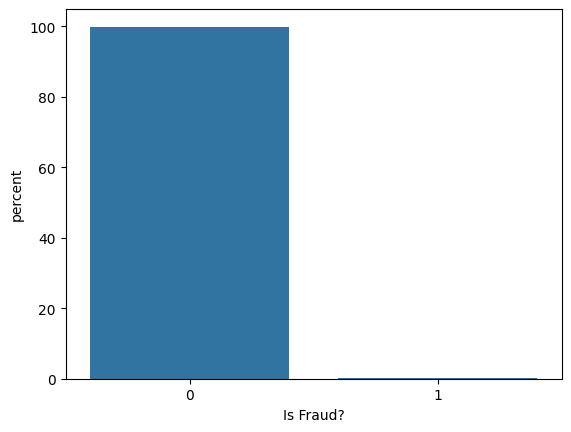

In [1813]:
print(transactions_df['Is Fraud?'].value_counts())
sns.countplot(x='Is Fraud?', data=transactions_df, stat='percent')

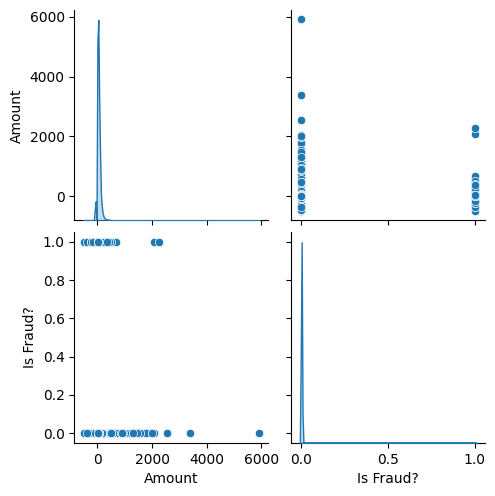

In [1814]:
sns.pairplot(transactions_df[['Amount', 'Is Fraud?']],diag_kind='kde')

We can see that based on this dataset, fraudulent transactions tend to have a smaller amount. There are a few exceptions though. So the amount of the transaction is worth considering.

As for the chip:

<Axes: xlabel='Use Chip', ylabel='count'>

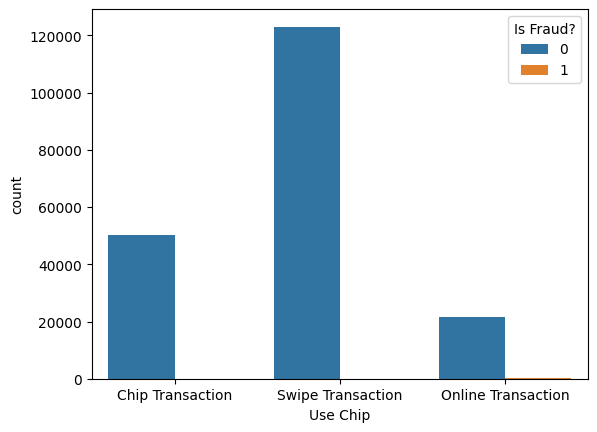

In [1815]:
sns.countplot(x='Use Chip', hue='Is Fraud?', data=transactions_df)

In [1816]:
is_fraud_by_trn_type = pd.crosstab(transactions_df['Is Fraud?'], transactions_df['Use Chip'], dropna=False, margins=True).T
is_fraud_by_trn_type

Is Fraud?,0,1,All
Use Chip,,,
Chip Transaction,50359,33,50392
Online Transaction,21569,149,21718
Swipe Transaction,123032,58,123090
All,194960,240,195200


We can see that the number of fraudulent transactions are online transactions, with the other types not even visible on the graph. This metric is definitely worth considering when choosing the attributes for the transaction nodes of the graph.

Now let's look at how the time of the transaction relates to whether it is fraudulent:

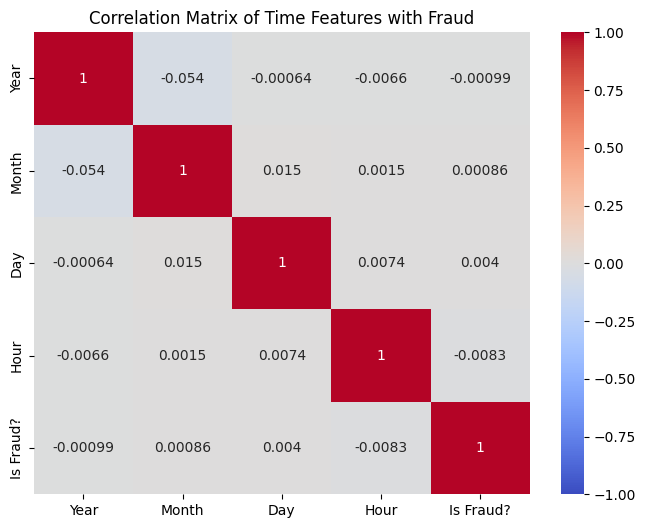

In [1817]:
transactions_df[['Hour', 'Minute']] = transactions_df['Time'].str.split(':', expand=True)

corr_matrix = transactions_df[['Year','Month','Day','Hour', 'Is Fraud?']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Time Features with Fraud')
plt.show()

It would seem that based on the dataset, only the month is more likely to show a relationship with the fraudulent activity, but even that value is too small to show a meaningful correlation.

Let's do the same for the merchant data:

In [1818]:
fraud_data = transactions_df[transactions_df['Is Fraud?'] == 1]
fraud_data

,TrnID,CardID,UserID,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
24032,220,7,1,2008,12,10,07:40,61.14,Swipe Transaction,-2306309531021796549,Ozone Park,NY,11417.0,5411,NaN,1,07,40
21031,423,6,1,2016,6,9,10:08,181.74,Online Transaction,-6761066196029841443,ONLINE,NaN,NaN,5310,NaN,1,10,08
4102,503,0,0,2015,11,16,09:46,248.36,Online Transaction,4872340518840476610,ONLINE,NaN,NaN,5732,NaN,1,09,46
66599,561,14,2,2013,10,11,07:21,142.82,Online Transaction,-4282466774399734331,ONLINE,NaN,NaN,4829,NaN,1,07,21
197724,1470,38,13,2015,8,3,10:36,2.74,Online Transaction,-4752064311331295725,ONLINE,NaN,NaN,4214,NaN,1,10,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23410708,187328,5892,1913,2010,11,15,13:06,8.90,Online Transaction,3189517333335617109,ONLINE,NaN,NaN,5311,NaN,1,13,06
23984856,191625,6037,1961,2016,3,29,11:41,360.00,Online Transaction,-1908131910424232363,ONLINE,NaN,NaN,3771,NaN,1,11,41
23901716,191721,6014,1954,2008,7,3,11:01,28.60,Online Transaction,-5581123930363301609,ONLINE,NaN,NaN,5311,NaN,1,11,01
23987715,191841,6038,1962,2006,4,29,13:38,9.38,Swipe Transaction,-2985456613733500756,Algiers,Algeria,NaN,7011,NaN,1,13,38


<Axes: xlabel='Percentage', ylabel='Merchant State'>

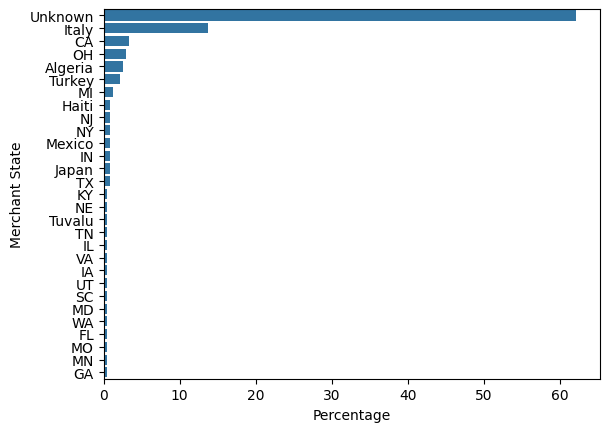

In [1819]:
fraud_percent = (fraud_data['Merchant State'].fillna('Unknown')
                 .value_counts(normalize=True) * 100)

fraud_percent_df = fraud_percent.reset_index()
fraud_percent_df.columns = ['Merchant State', 'Percentage']

sns.barplot(x='Percentage', y='Merchant State', data=fraud_percent_df, order=fraud_percent_df.sort_values('Percentage', ascending=False)['Merchant State'])

There is a big portion of fraudulent transactions whose Merchant state is either Italy, California or Ohio. This may indicate that transactions to such merchants may have a higher tendency to be fraudulent. Definitely worth considering this feature.

Merchant Category Codes(MCCs) are codes, that are assigned to the transactions based on the type of merchant to which the transaction was made. They are supposed to categorize the type of merchant. Let's see how these categories relate to our fraudulent transactions:

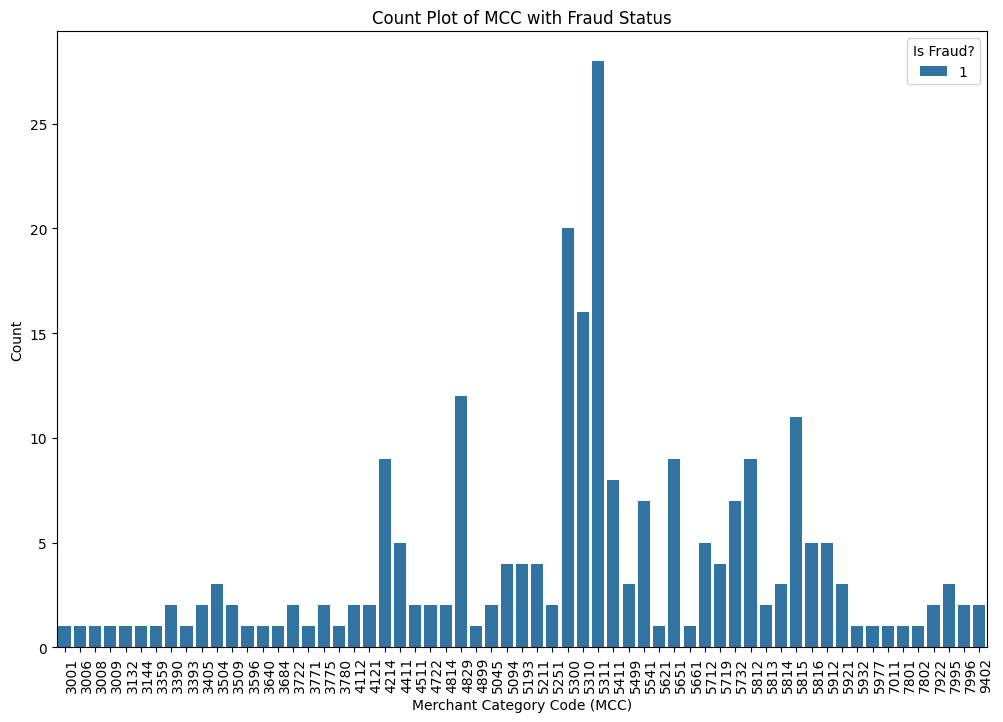

In [1820]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(x='MCC', hue='Is Fraud?', data=fraud_data)
plt.xticks(rotation=90, ha='left') 
plt.xlabel('Merchant Category Code (MCC)')
plt.ylabel('Count')
plt.title('Count Plot of MCC with Fraud Status')
plt.show()

We can clearly see that there are MCCs that have a lot less fraudulent transactions than others. Worth considering.

Let's do the same for the merchant name:

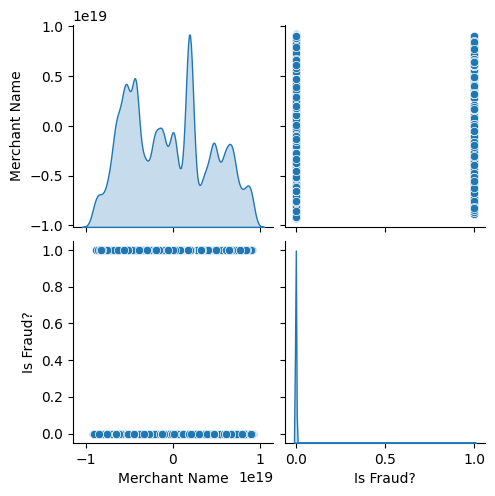

In [1821]:
sns.pairplot(transactions_df[['Merchant Name', 'Is Fraud?']],diag_kind='kde')

As we can see, the trancations are uniformly distributed amonnd the merchants, so this column would not be useful. Also, there are too many missing values for the Errors column to be considered. 

### Columns to be used as features for the transaction node: Amount, Use Chip, Merchant State, MCC

Now it's time for analyzing the credit card dataset. We will start by making a map between the cards and their transactions, tracking fraud proportion.

In [1822]:
cards_df['Credit Limit'] = cards_df['Credit Limit'].replace('[\$,]', '', regex=True).astype(float)

In [1823]:
fraud_counts = transactions_df.groupby('CardID').agg(
    total_transactions=('Is Fraud?', 'count'),
    fraud_transactions=('Is Fraud?', 'sum')
)
fraud_counts['fraud_rate'] = fraud_counts['fraud_transactions'] / fraud_counts['total_transactions']
fraud_counts['has_fraud'] = fraud_counts['fraud_transactions'] > 0
cards_with_fraud = cards_df.merge(fraud_counts, left_on='CardID', right_on='CardID')

In [1824]:
fraud_counts

,total_transactions,fraud_transactions,fraud_rate,has_fraud
CardID,,,,
0,41,1,0.024390,True
1,7,0,0.000000,False
2,36,0,0.000000,False
3,72,0,0.000000,False
6,12,1,0.083333,True
...,...,...,...,...
6140,23,0,0.000000,False
6141,137,0,0.000000,False
6142,33,0,0.000000,False


<Axes: xlabel='Credit Limit', ylabel='fraud_rate'>

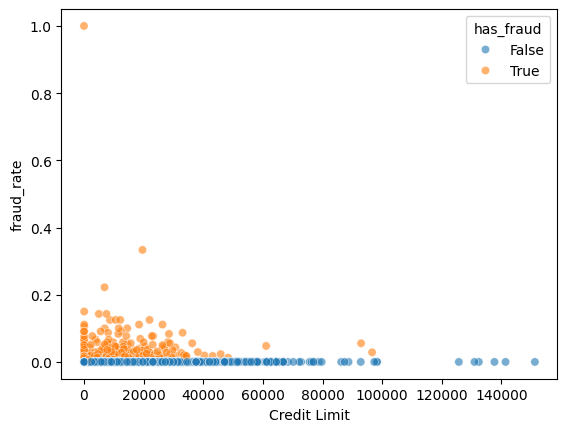

In [1825]:
sns.scatterplot(data=cards_with_fraud, x='Credit Limit', y='fraud_rate', hue='has_fraud', alpha=0.6)

It seems that fraudulent transactions tend to be made with cards that have a lower credit limit(specifically, below 10 000$). Worth adding as a feature to our model.

In [1826]:
def create_count_plot(ax):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='bottom')    

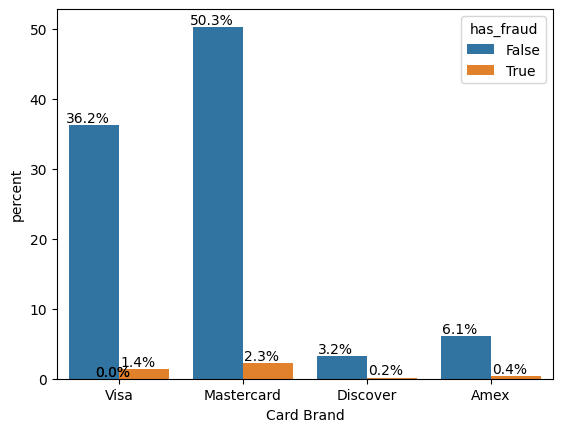

In [1827]:
fraud_by_brand_plot = sns.countplot(data=cards_with_fraud, x='Card Brand', hue='has_fraud', stat='percent')
create_count_plot(fraud_by_brand_plot)
plt.show()

Based on the percentages above we can see that Mastercard cards are less likely to be used for fraudulent transactions: Fraudulent to non-fraudulent ratio is 1/25 for Mastercard and around 1/15 for the others. Worth considering.

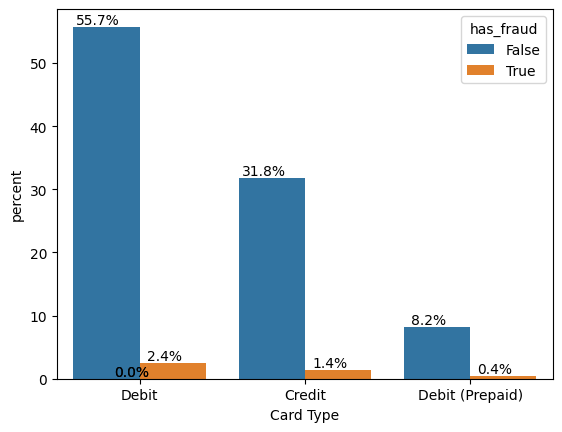

In [1828]:
fraud_by_type_plot = sns.countplot(data=cards_with_fraud, x='Card Type', hue='has_fraud', stat='percent')
create_count_plot(fraud_by_type_plot)
plt.show()

The above graph shows that the ratio between fraudulent and non-fraudulent transactions based on the card type remains mostly the same(around 0.045). This feature would not be useful for our model.

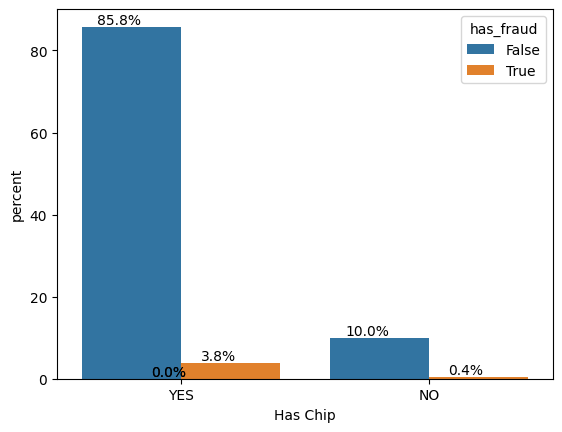

In [1829]:
fraud_by_chip_plot = sns.countplot(data=cards_with_fraud, x='Has Chip', hue='has_fraud', stat='percent')
create_count_plot(fraud_by_chip_plot)
plt.show()

Here the ration remains the same(around 0.04-0.045). Not useful for the model.

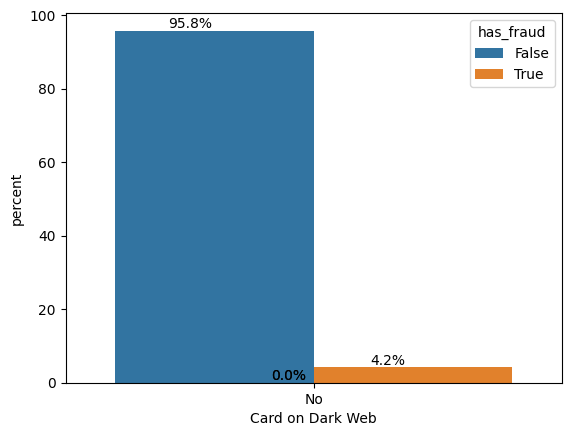

In [1830]:
fraud_by_is_on_dark_web = sns.countplot(data=cards_with_fraud, x='Card on Dark Web', hue='has_fraud', stat='percent')
create_count_plot(fraud_by_is_on_dark_web)
plt.show()

In [1831]:
cards_df.describe(include='object').T

,count,unique,top,freq
Card Brand,6146,4,Mastercard,3209
Card Type,6146,3,Debit,3511
Expires,6146,259,02/2020,377
Has Chip,6146,2,YES,5500
Acct Open Date,6146,303,02/2020,607
Card on Dark Web,6146,1,No,6146


It seems our dataset has no cards that were used in the dark web, so this column would not be of use to us.

<Axes: xlabel='has_fraud', ylabel='Account Age'>

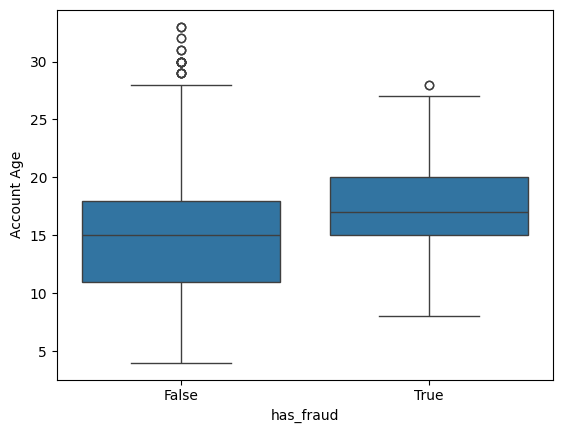

In [1832]:
cards_with_fraud['Account Age'] = 2024 - pd.to_datetime(cards_with_fraud['Acct Open Date'], format='%m/%Y').dt.year
sns.boxplot(data=cards_with_fraud, x='has_fraud', y='Account Age')


It seems that fraudulent activity is more likely with accounts, that are a bit older(minimum value of boxplot is higher for fraudulent cards). A look over the distribution proves it:

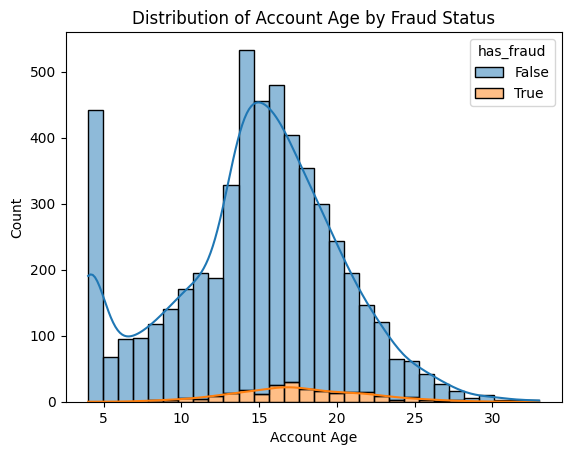

In [1833]:
sns.histplot(data=cards_with_fraud, x='Account Age', hue='has_fraud', multiple='stack', bins=30, kde=True)
plt.title('Distribution of Account Age by Fraud Status')
plt.xlabel('Account Age')
plt.ylabel('Count')
plt.show()

The reason for that may be due to the fact that cards related to accounts created several years ago may appear more trustworthy, as they will have transactions made. Worth considering for the model.

<Axes: xlabel='has_fraud', ylabel='Expires_Year'>

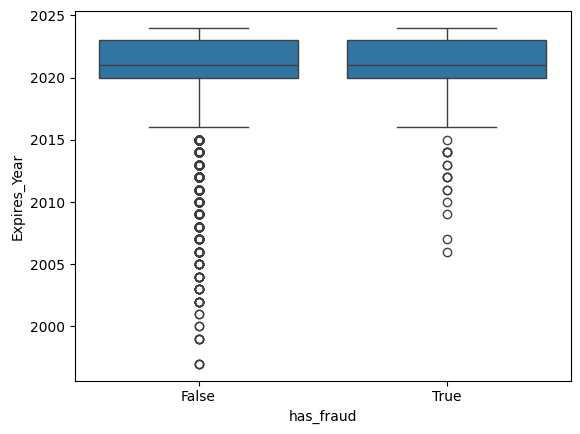

In [1834]:
cards_with_fraud['Expires_Year'] = pd.to_datetime(cards_with_fraud['Expires'],format='%m/%Y').dt.year
sns.boxplot(data=cards_with_fraud, x='has_fraud', y='Expires_Year')

The distributions seem to be mostly the same, so we can conclude that this feature would not be useful to the model.

### Columns to be used as features for the card node: Credit Limit, Card Brand and Account Age

Now it is time to look at the users dataset.

In [1835]:
users_df.describe(include='object').T

,count,unique,top,freq
Person,2000,1993,Hazel Robinson,2
Gender,2000,2,Female,1016
Address,2000,1999,506 Washington Lane,2
City,2000,1286,Houston,22
State,2000,51,CA,244
Per Capita Income - Zipcode,2000,1754,$0,15
Yearly Income - Person,2000,1948,$44128,3
Total Debt,2000,1880,$0,102


In [1836]:
users_df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
UserID,2000.0,999.500000,577.494589,0.00,499.7500,999.50,1499.25,1999.00
Current Age,2000.0,45.391500,18.414092,18.00,30.0000,44.00,58.00,101.00
Retirement Age,2000.0,66.237500,3.628867,50.00,65.0000,66.00,68.00,79.00
Birth Year,2000.0,1973.803000,18.421234,1918.00,1961.0000,1975.00,1989.00,2002.00
Birth Month,2000.0,6.439000,3.565338,1.00,3.0000,7.00,10.00,12.00
Apartment,528.0,693.547348,1897.157861,1.00,5.0000,10.00,95.25,9940.00
Zipcode,2000.0,50535.412000,29359.754742,1060.00,28214.2500,46305.50,77086.25,99508.00
Latitude,2000.0,37.389225,5.114324,20.88,33.8375,38.25,41.20,61.20
Longitude,2000.0,-91.554765,16.283293,-159.41,-97.3950,-86.44,-80.13,-68.67
FICO Score,2000.0,709.734500,67.221949,480.00,681.0000,711.50,753.00,850.00


First, let's convert all amount columns into the proper numerical format:

In [1837]:
users_df['Per Capita Income - Zipcode'] = users_df['Per Capita Income - Zipcode'].replace('[\$,]', '', regex=True).astype(float)
users_df['Yearly Income - Person'] = users_df['Yearly Income - Person'].replace('[\$,]', '', regex=True).astype(float)
users_df['Total Debt'] = users_df['Total Debt'].replace('[\$,]', '', regex=True).astype(float)

In [1838]:
users_df.describe(include='object').T

,count,unique,top,freq
Person,2000,1993,Hazel Robinson,2
Gender,2000,2,Female,1016
Address,2000,1999,506 Washington Lane,2
City,2000,1286,Houston,22
State,2000,51,CA,244


In [1839]:
users_df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
UserID,2000.0,999.500000,577.494589,0.00,499.7500,999.50,1499.25,1999.00
Current Age,2000.0,45.391500,18.414092,18.00,30.0000,44.00,58.00,101.00
Retirement Age,2000.0,66.237500,3.628867,50.00,65.0000,66.00,68.00,79.00
Birth Year,2000.0,1973.803000,18.421234,1918.00,1961.0000,1975.00,1989.00,2002.00
Birth Month,2000.0,6.439000,3.565338,1.00,3.0000,7.00,10.00,12.00
Apartment,528.0,693.547348,1897.157861,1.00,5.0000,10.00,95.25,9940.00
Zipcode,2000.0,50535.412000,29359.754742,1060.00,28214.2500,46305.50,77086.25,99508.00
Latitude,2000.0,37.389225,5.114324,20.88,33.8375,38.25,41.20,61.20
Longitude,2000.0,-91.554765,16.283293,-159.41,-97.3950,-86.44,-80.13,-68.67
Per Capita Income - Zipcode,2000.0,23141.928000,11324.137358,0.00,16824.5000,20581.00,26286.00,163145.00


As we can see, the columns were converted properly into numerical type. Now let's aggregate the users data with the transactions data in oder to do EDA based on the fraudulent activity.

In [1840]:
fraud_counts_users = transactions_df.groupby('UserID').agg(
    total_transactions=('Is Fraud?', 'count'),
    fraud_transactions=('Is Fraud?', 'sum')
)

users_with_fraud = users_df.merge(fraud_counts_users, left_on='UserID', right_on='UserID', how='left')

users_with_fraud.fillna({'total_transactions':0}, inplace=True)
users_with_fraud.fillna({'fraud_transactions':0}, inplace=True)

users_with_fraud['fraud_rate'] = users_with_fraud['fraud_transactions'] / users_with_fraud['total_transactions']

users_with_fraud.fillna({'fraud_rate':0}, inplace=True)

users_with_fraud['has_fraud'] = users_with_fraud['fraud_transactions'] > 0

In [1841]:
users_with_fraud[['UserID', 'total_transactions', 'fraud_transactions', 'fraud_rate', 'has_fraud']]

,UserID,total_transactions,fraud_transactions,fraud_rate,has_fraud
0,0,156.0,1.0,0.006410,True
1,1,67.0,2.0,0.029851,True
2,2,345.0,1.0,0.002899,True
3,3,79.0,0.0,0.000000,False
4,4,149.0,0.0,0.000000,False
...,...,...,...,...,...
1995,1995,141.0,0.0,0.000000,False
1996,1996,158.0,0.0,0.000000,False
1997,1997,193.0,0.0,0.000000,False
1998,1998,61.0,0.0,0.000000,False


In [1842]:
users_with_fraud.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
UserID,2000.0,999.500000,577.494589,0.00,499.7500,999.50,1499.25,1999.000000
Current Age,2000.0,45.391500,18.414092,18.00,30.0000,44.00,58.00,101.000000
Retirement Age,2000.0,66.237500,3.628867,50.00,65.0000,66.00,68.00,79.000000
Birth Year,2000.0,1973.803000,18.421234,1918.00,1961.0000,1975.00,1989.00,2002.000000
Birth Month,2000.0,6.439000,3.565338,1.00,3.0000,7.00,10.00,12.000000
Apartment,528.0,693.547348,1897.157861,1.00,5.0000,10.00,95.25,9940.000000
Zipcode,2000.0,50535.412000,29359.754742,1060.00,28214.2500,46305.50,77086.25,99508.000000
Latitude,2000.0,37.389225,5.114324,20.88,33.8375,38.25,41.20,61.200000
Longitude,2000.0,-91.554765,16.283293,-159.41,-97.3950,-86.44,-80.13,-68.670000
Per Capita Income - Zipcode,2000.0,23141.928000,11324.137358,0.00,16824.5000,20581.00,26286.00,163145.000000


In [1843]:
users_with_fraud.describe(include='object').T

,count,unique,top,freq
Person,2000,1993,Hazel Robinson,2
Gender,2000,2,Female,1016
Address,2000,1999,506 Washington Lane,2
City,2000,1286,Houston,22
State,2000,51,CA,244


The only missing values we have are in the apartment column and they are around 75% missing, so the column should not be considered. Furthermore, I don't see how we can replace the missing values properly.

In [1844]:
def create_box_plot(feature):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=users_with_fraud, x='has_fraud', y=feature)
    plt.title(f'{feature} by Fraud Status')
    plt.xlabel('Has Fraud')
    plt.ylabel(feature)
    plt.show()

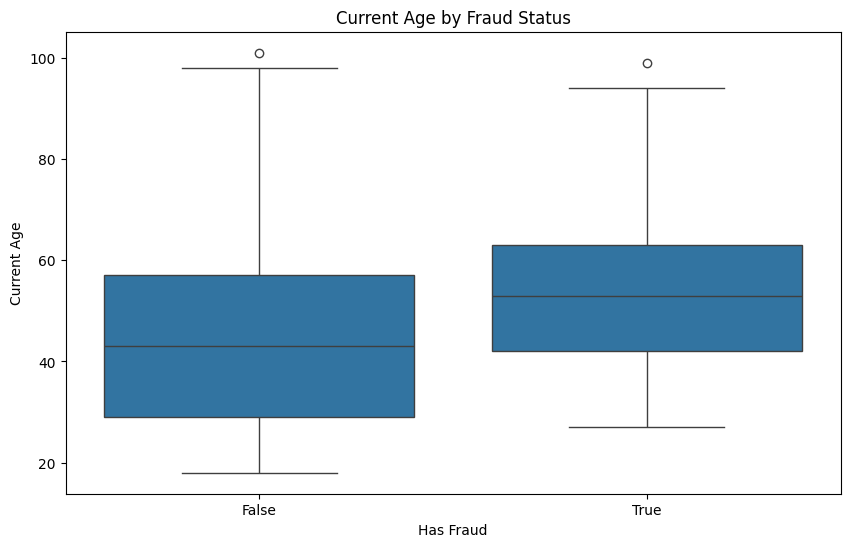

In [1845]:
create_box_plot('Current Age')

It would seem that the users doing fraud are in a closer age range compared to non-fraudulent users. They also seem to be mostly a bit older. Worth considering this feature.

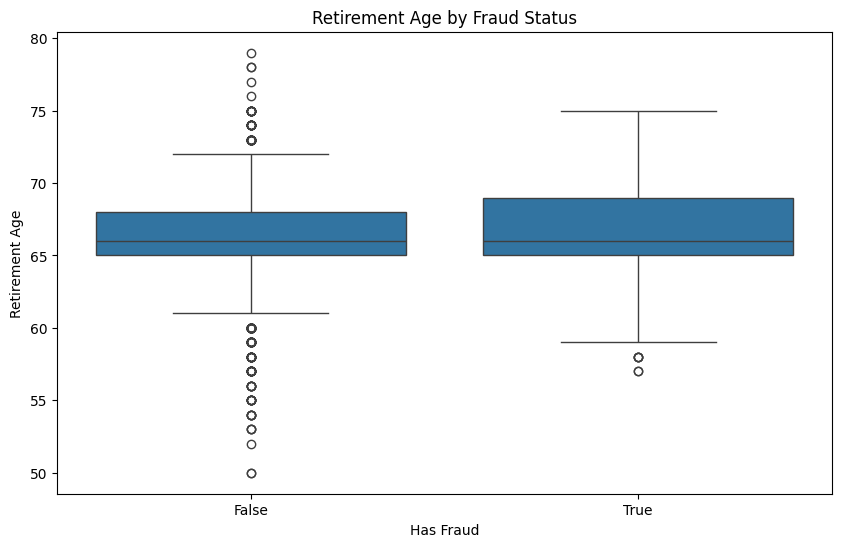

In [1846]:
create_box_plot('Retirement Age')

The retirement age makes no difference as the distribution appears to be similar, with the exception of a few outliers.

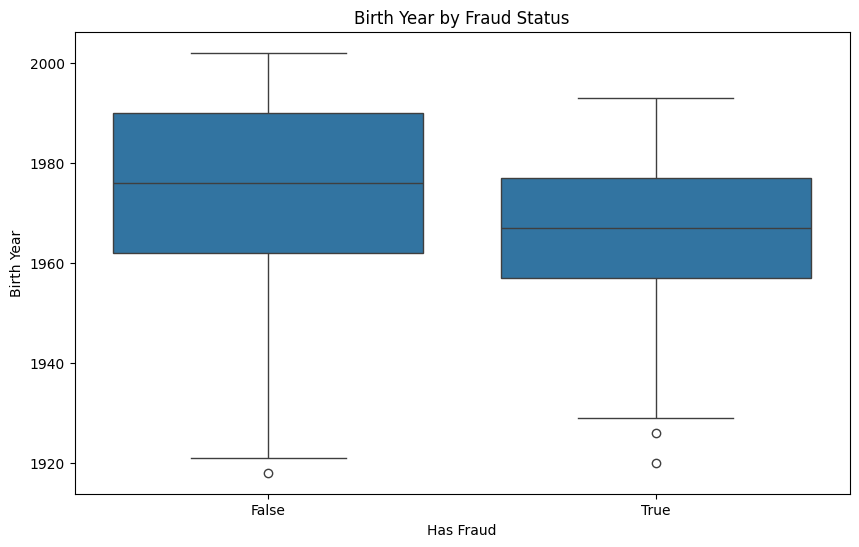

In [1847]:
create_box_plot('Birth Year')

Fraudulent users tend to be a bit older, as previously pointed out. This plot further solidifies it. However, using both features would not bring us additional info. Either the current age or the birth year should be used, but using both would be redundant.

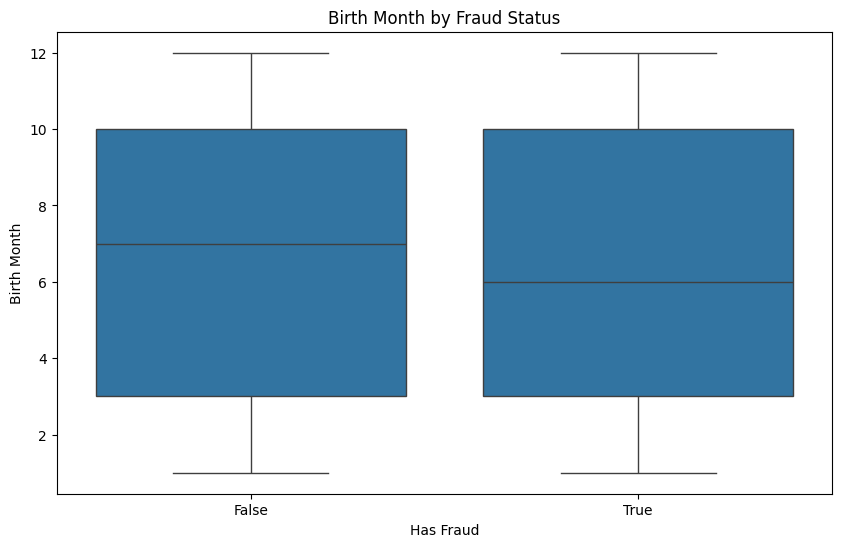

In [1848]:
create_box_plot('Birth Month')

Both distributions are very similar, as expected, because whether the person was born in august or december shouldn't make much of a difference in their choices. Such choices are much more likely to be influenced by age, which was already covered. Not worth considering the feature.

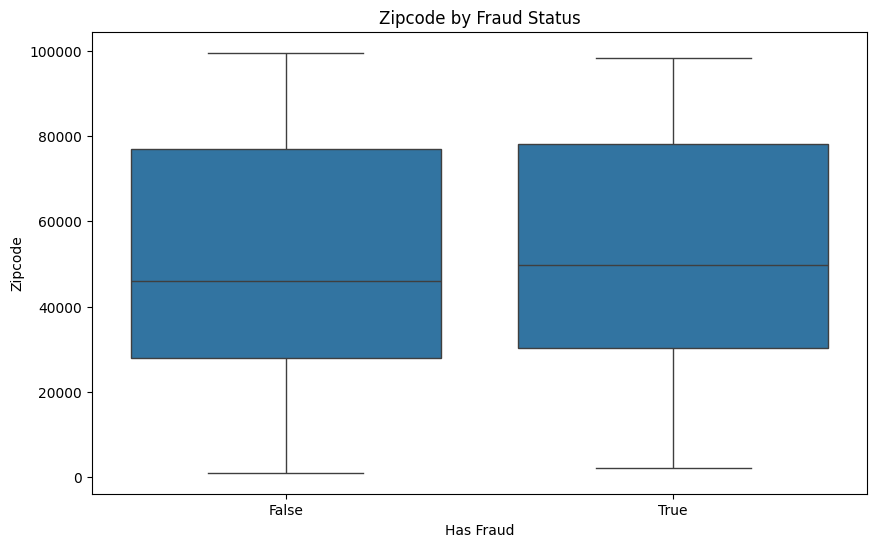

In [1849]:
create_box_plot('Zipcode')

Both distributions are very similar. Not worth considering the feature.

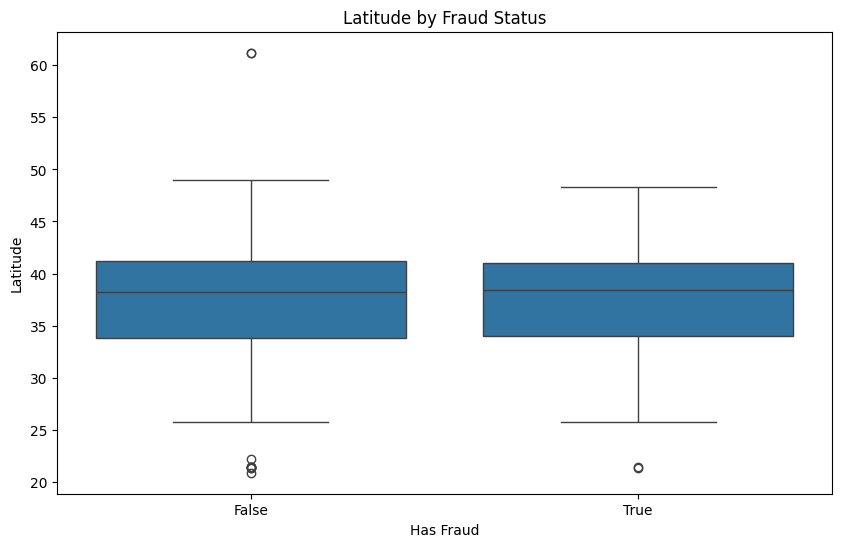

In [1850]:
create_box_plot('Latitude')

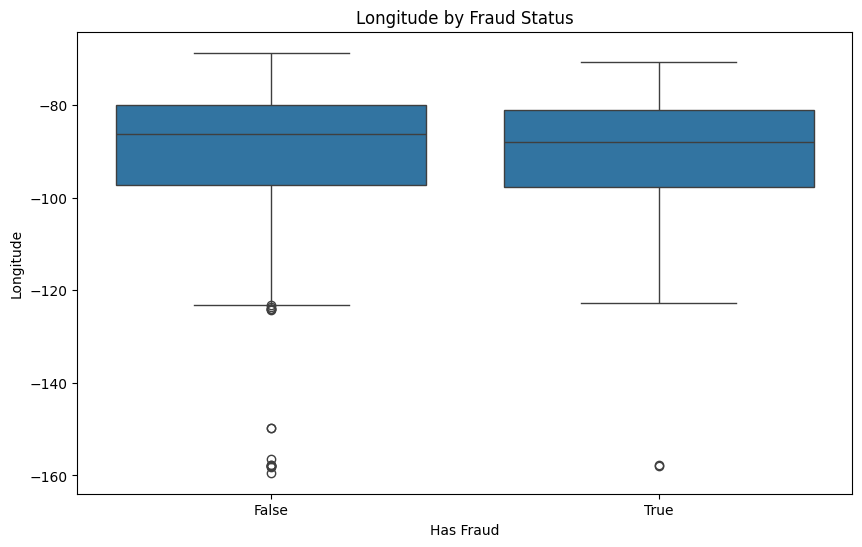

In [1851]:
create_box_plot('Longitude')

As expected, latitude and longitude distributions are mostly the same for both fraudulent and non-fraudulent users. However, together they may give us useful info.

<Axes: xlabel='Latitude', ylabel='Longitude'>

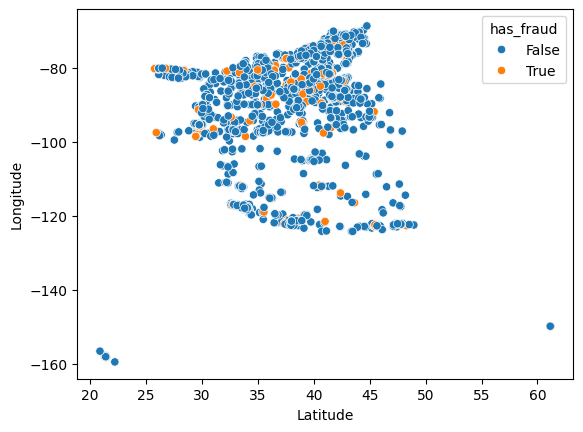

In [1852]:
sns.scatterplot(data=users_with_fraud, x='Latitude', y='Longitude', hue='has_fraud')

It seems that all fraudulent activity is done by users in the [25,50],[-70,-125] range. This gives us bounds on the fraudulent users location. Definitely worth considering.

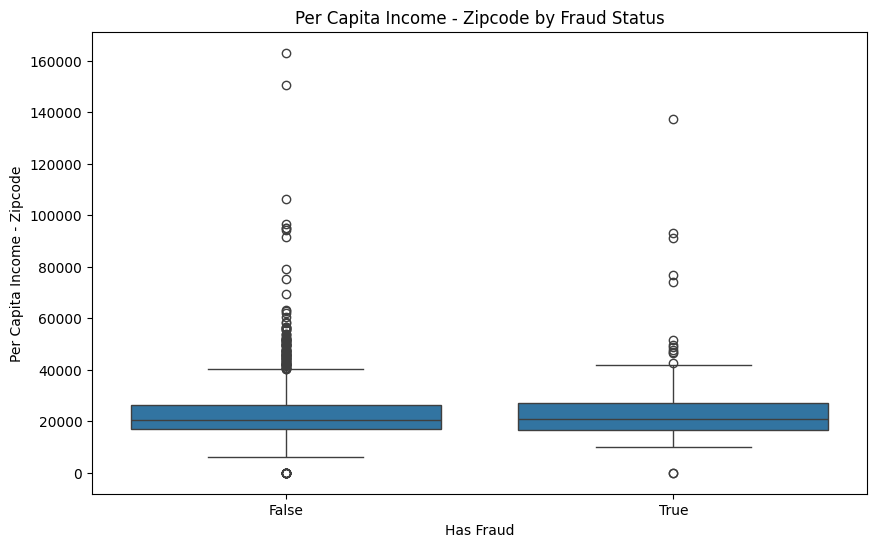

In [1853]:
create_box_plot('Per Capita Income - Zipcode')

Similar distributions, not worth considering.

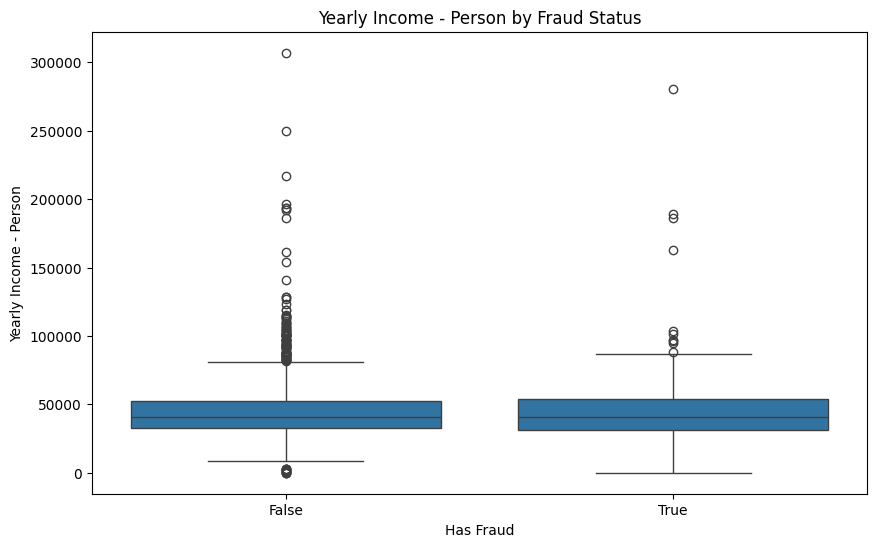

In [1854]:
create_box_plot('Yearly Income - Person')

The yearly income seems to not be making a difference in whether the user would be fraudulent.

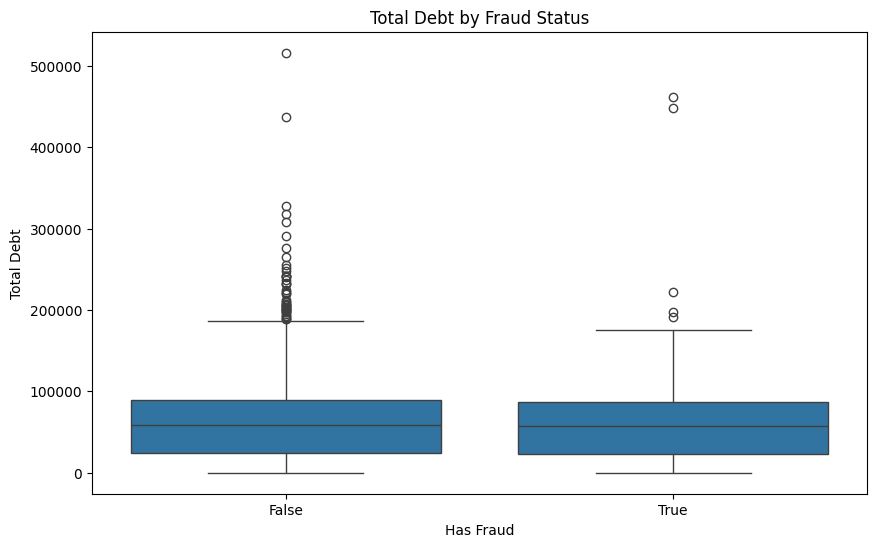

In [1855]:
create_box_plot('Total Debt')

Again, the distributions are almost identical(with the exception of outliers), so this feature would not be useful for our model.

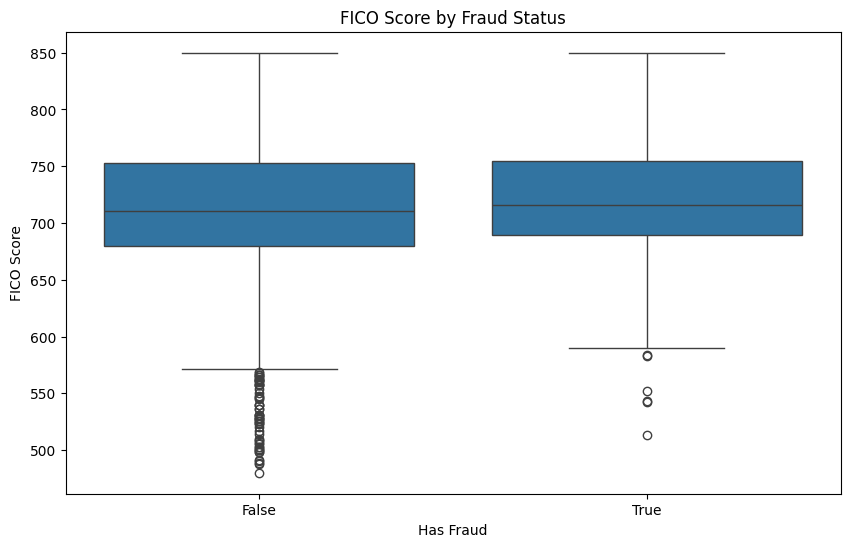

In [1856]:
create_box_plot('FICO Score')

Again, similar distributions. It seems fraudulent users tend to hide behind a good credit score. There are a lot less outliers for fraudulent users but that does not directly indicate fraudulent behaviour.

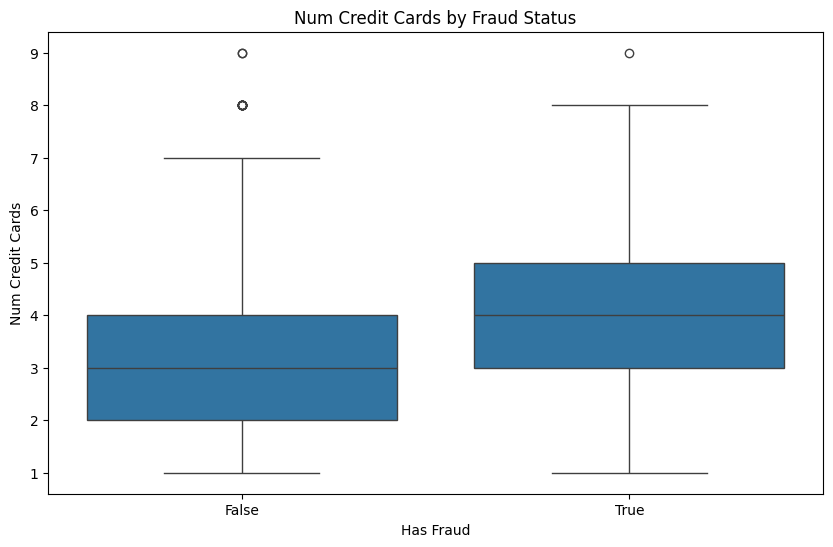

In [1857]:
create_box_plot('Num Credit Cards')

It seems that fraudulent users tend to have a higher number of credit cards than non-fraudulent users. Worth considering.

Now, let's look at the categorical variables:

The person and Address features have too many unique values to be considered. Let's look at the gender distribution:

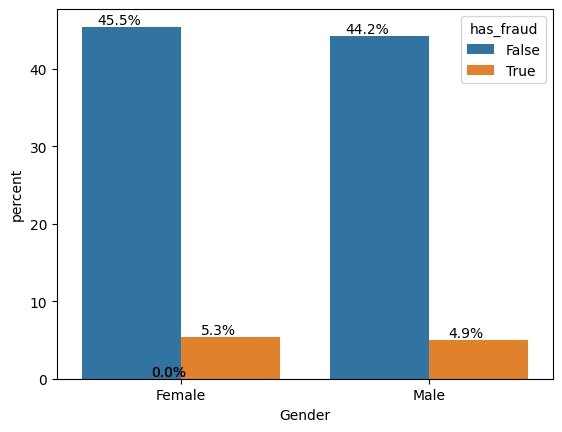

In [1858]:
user_fraud_by_gender_plot = sns.countplot(data=users_with_fraud, x='Gender', hue='has_fraud', stat='percent')
create_count_plot(user_fraud_by_gender_plot)
plt.show()

We can see that the fraudulent users are around 10% for both male and female users. This feature would not be useful to the model.

Let's now take a look at the state distribution:

C:\Users\Acer\AppData\Local\Temp\ipykernel_19744\1490771209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='fraud_percentage', y='State', data=fraud_by_state, palette='viridis')


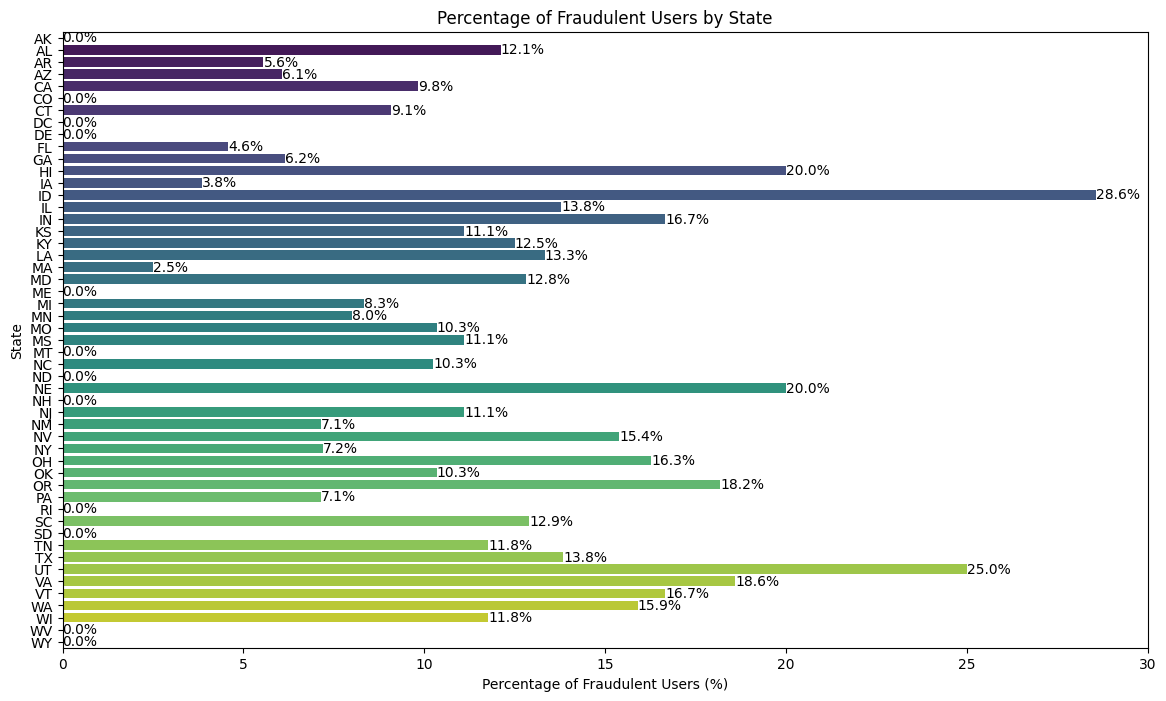

In [1859]:
fraud_by_state = users_with_fraud.groupby('State')['has_fraud'].mean().reset_index()
fraud_by_state['fraud_percentage'] = fraud_by_state['has_fraud'] * 100


plt.figure(figsize=(14, 8))
ax = sns.barplot(x='fraud_percentage', y='State', data=fraud_by_state, palette='viridis')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.1f}%', 
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center')

plt.xlabel('Percentage of Fraudulent Users (%)')
plt.ylabel('State')
plt.title('Percentage of Fraudulent Users by State')

plt.show()

So it seems that some states are showing a lot more fraudulent activity than others. Worth considering this feature.

In [1860]:
fraud_by_city = users_with_fraud.groupby('City')['has_fraud'].mean().reset_index()
fraud_by_city.rename(columns={'has_fraud': 'fraud_percentage'}, inplace=True)
fraud_by_city['fraud_percentage'] *= 100
fraud_by_city

,City,fraud_percentage
0,Abbeville,0.0
1,Aberdeen,0.0
2,Abilene,0.0
3,Acworth,0.0
4,Adrian,0.0
...,...,...
1281,Yuma,0.0
1282,Zebulon,0.0
1283,Zephyrhills,0.0
1284,Zion,0.0


In [1861]:
fraud_by_city_filtered = fraud_by_city[fraud_by_city['fraud_percentage'] > 0]

fraud_by_city_filtered

,City,fraud_percentage
9,Albany,33.333333
10,Albuquerque,14.285714
13,Alhambra,50.000000
19,Alpine,100.000000
22,Alvin,100.000000
...,...,...
1247,Wildersville,100.000000
1255,Wilmore,100.000000
1267,Woodland Hills,100.000000
1270,Woodway,100.000000


We can see that there are 192 cities, where there is fraudulent activity(a lot less than the unique values). Definitely worth considering.

### User features to be used in the model: Current Age, Latitude, Longitude, Num Credit Cards, State, City

#### Now, let's continue with feature engineering.

First we will take a look at the users data, more specifically, the necessary columns for our user node:

In [1862]:
user_data_to_be_used = users_with_fraud[['Current Age', 'Latitude', 'Longitude', 'Num Credit Cards', 'State', 'City']]
user_data_to_be_used.describe(include='all')

,Current Age,Latitude,Longitude,Num Credit Cards,State,City
count,2000.000000,2000.000000,2000.000000,2000.000000,2000,2000
unique,NaN,NaN,NaN,NaN,51,1286
top,NaN,NaN,NaN,NaN,CA,Houston
freq,NaN,NaN,NaN,NaN,244,22
mean,45.391500,37.389225,-91.554765,3.073000,NaN,NaN
std,18.414092,5.114324,16.283293,1.637379,NaN,NaN
min,18.000000,20.880000,-159.410000,1.000000,NaN,NaN
25%,30.000000,33.837500,-97.395000,2.000000,NaN,NaN
50%,44.000000,38.250000,-86.440000,3.000000,NaN,NaN
75%,58.000000,41.200000,-80.130000,4.000000,NaN,NaN


Now let's do feature engineering on the categorical variables using one-hot encoding and then PCA for dimensionality reduction:

In [1863]:
encoder = OneHotEncoder()

ct = ColumnTransformer(transformers=[('encoder', encoder, ['State', 'City'])], remainder='passthrough')

user_data_encoded_array = ct.fit_transform(user_data_to_be_used)  
print(user_data_encoded_array.shape)
print(ct.get_feature_names_out().size)

#this was necessary due to the fact that the encoder uses a sparse matrix to save memory, 
#which required a dense array in order for pandas to be able to convert it to a dataframe properly
if isinstance(user_data_encoded_array, csr_matrix):
    user_data_encoded_array = user_data_encoded_array.toarray()

user_data_encoded = pd.DataFrame(user_data_encoded_array, columns=ct.get_feature_names_out())

(2000, 1341)
1341


In [1864]:
user_data_encoded.info()
user_data_encoded.describe(include='number')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 1341 entries, encoder__State_AK to remainder__Num Credit Cards
dtypes: float64(1341)
memory usage: 20.5 MB


,encoder__State_AK,encoder__State_AL,encoder__State_AR,encoder__State_AZ,encoder__State_CA,encoder__State_CO,encoder__State_CT,encoder__State_DC,encoder__State_DE,encoder__State_FL,...,encoder__City_Ypsilanti,encoder__City_Yuma,encoder__City_Zebulon,encoder__City_Zephyrhills,encoder__City_Zion,encoder__City_Zion Grove,remainder__Current Age,remainder__Latitude,remainder__Longitude,remainder__Num Credit Cards
count,2000.000000,2000.00000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.001000,0.01650,0.009000,0.01650,0.122000,0.011500,0.011000,0.000500,0.003500,0.065500,...,0.000500,0.000500,0.000500,0.000500,0.000500,0.000500,45.391500,37.389225,-91.554765,3.073000
std,0.031615,0.12742,0.094464,0.12742,0.327368,0.106646,0.104329,0.022361,0.059072,0.247468,...,0.022361,0.022361,0.022361,0.022361,0.022361,0.022361,18.414092,5.114324,16.283293,1.637379
min,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,20.880000,-159.410000,1.000000
25%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,33.837500,-97.395000,2.000000
50%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,38.250000,-86.440000,3.000000
75%,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,41.200000,-80.130000,4.000000
max,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,101.000000,61.200000,-68.670000,9.000000


In [1865]:
scaler = StandardScaler()
user_data_standardized = scaler.fit_transform(user_data_encoded)
user_data_standardized_df = pd.DataFrame(user_data_standardized, columns=user_data_encoded.columns)

As we can see, now all columns are numerical but the problem is there are far too many features. We need to apply dimensionality reduction. First, we need to separate the encoded columns from the rest, as we want PCA to be applied only to them.

In [1866]:
user_encoded_columns = user_data_standardized_df.loc[:, ~user_data_standardized_df.columns.str.startswith('remainder_')]  
user_remainder_columns = user_data_standardized_df.loc[:, user_data_standardized_df.columns.str.startswith('remainder_')]

A quick check that the separation was successful.

In [1867]:
print(user_encoded_columns.shape)
print(user_remainder_columns.shape)
user_remainder_columns.info()

(2000, 1337)
(2000, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   remainder__Current Age       2000 non-null   float64
 1   remainder__Latitude          2000 non-null   float64
 2   remainder__Longitude         2000 non-null   float64
 3   remainder__Num Credit Cards  2000 non-null   float64
dtypes: float64(4)
memory usage: 62.6 KB


Now let's do the PCA. Passing a float between 0 and 1 for n_components will tell the method to create as many features as needed in order to keep the variance close to that number as much as possible.

In [1868]:
pca = PCA(n_components=0.80)
encoded_columns_pca = pca.fit_transform(user_encoded_columns)
pca_column_names = [f'PCA_{i+1}' for i in range(encoded_columns_pca.shape[1])]
user_final_data = np.concatenate((encoded_columns_pca, user_remainder_columns.values), axis=1)
final_column_names = pca_column_names + list(user_remainder_columns.columns)

user_final_data_df = pd.DataFrame(user_final_data, columns=final_column_names)

In [1869]:
user_final_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 1025 entries, PCA_1 to remainder__Num Credit Cards
dtypes: float64(1025)
memory usage: 15.6 MB


In [1870]:
user_final_data_df.describe()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_1016,PCA_1017,PCA_1018,PCA_1019,PCA_1020,PCA_1021,remainder__Current Age,remainder__Latitude,remainder__Longitude,remainder__Num Credit Cards
count,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,...,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,4.272138e-16,2.042810e-16,1.140421e-15,3.517187e-16,-6.892265e-16,4.334311e-16,-6.048495e-16,2.655653e-16,6.323830e-16,-8.899548e-16,...,-1.392664e-15,9.769963e-17,-3.641532e-17,1.882938e-16,-8.437695e-18,7.327472e-17,-3.552714e-17,2.159783e-14,-3.296918e-15,1.865175e-17
std,1.451846e+00,1.435369e+00,1.432685e+00,1.425121e+00,1.422033e+00,1.419140e+00,1.418158e+00,1.417638e+00,1.417298e+00,1.417108e+00,...,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00
min,-1.303082e+00,-1.504187e+00,-1.801443e+00,-4.108643e+00,-2.574043e+00,-3.208865e+00,-2.525959e+00,-4.846529e+00,-5.488134e+00,-6.823249e+00,...,-4.929714e+00,-8.857469e+00,-7.899181e+00,-7.696234e+00,-7.229610e+00,-6.093198e+00,-1.487901e+00,-3.228844e+00,-4.168211e+00,-1.266364e+00
25%,-5.788929e-01,-6.711468e-01,-6.550098e-01,-4.093803e-01,-8.393795e-01,-2.557457e-01,-3.507346e-01,-1.760670e-01,-1.342023e-01,-2.689839e-01,...,-2.554156e-01,-2.878339e-11,-1.357319e-11,-2.442097e-11,-2.013262e-11,-1.167672e-11,-8.360635e-01,-6.946399e-01,-3.587540e-01,-6.554793e-01
50%,-4.615710e-01,-4.029948e-01,-3.699541e-01,-2.125361e-01,-1.082858e-01,-5.164389e-02,-1.174021e-01,6.976478e-02,3.005020e-02,-2.694086e-02,...,-1.590356e-11,5.337086e-13,1.463958e-13,-6.688902e-13,-5.653494e-13,-4.159691e-13,-7.558603e-02,1.683488e-01,3.141898e-01,-4.459458e-02
75%,-2.790813e-01,1.254646e-01,4.540258e-01,3.649739e-01,3.994759e-01,7.009567e-02,1.379776e-01,2.532214e-01,2.409498e-01,5.173750e-02,...,-3.606472e-12,1.804341e-11,2.117946e-11,1.983234e-11,1.533661e-11,1.175864e-11,6.848914e-01,7.453044e-01,7.018005e-01,5.662901e-01
max,3.876498e+00,4.632386e+00,5.002335e+00,4.328394e+00,4.659999e+00,7.794291e+00,1.087491e+01,1.266904e+01,7.479604e+00,6.244610e+00,...,7.155213e+00,8.878286e+00,1.119470e+01,8.460353e+00,9.704733e+00,8.232452e+00,3.020644e+00,4.656868e+00,1.405765e+00,3.620714e+00


Now we need to merge it with the user ids:

In [1871]:
user_final_data_df['UserID'] = users_with_fraud['UserID']
user_final_data_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_1017,PCA_1018,PCA_1019,PCA_1020,PCA_1021,remainder__Current Age,remainder__Latitude,remainder__Longitude,remainder__Num Credit Cards,UserID
0,3.849993,0.490399,0.454026,0.083607,0.071087,-0.051644,-0.116935,0.069730,0.053888,-0.026941,...,-1.437311e-01,-3.473700e-03,1.346106e-01,5.272891e-02,5.689374e-02,0.413292,-0.633522,-1.609735,1.177175,0
1,-0.447065,-1.234679,-1.791955,4.305118,2.345377,0.463076,-0.350735,0.353282,0.354059,-0.394705,...,-1.556661e-02,-2.801117e-02,3.579058e-01,5.077927e-02,3.353674e-01,0.413292,0.659250,1.094325,1.177175,1
2,3.849993,0.490399,0.454026,0.083607,0.071087,-0.051644,-0.116935,0.069730,0.053888,-0.026941,...,-3.362116e-01,-7.115712e-02,2.308484e-01,2.406653e-01,1.000001e-01,1.934247,-0.658947,-1.617721,1.177175,2
3,-0.448696,-1.239385,-1.798835,4.321996,2.354651,0.464923,-0.352137,0.354696,0.355478,-0.396288,...,2.096556e-13,4.313031e-14,-1.250844e-12,-8.549880e-13,-1.096170e-12,0.956491,0.649471,1.078968,0.566290,3
4,3.858743,0.491564,0.455112,0.083811,0.071262,-0.051772,-0.117226,0.069904,0.054022,-0.027008,...,1.565924e-12,1.456110e-13,-2.691311e-12,-2.146387e-12,-1.805426e-12,-0.129906,0.072515,-1.897218,-1.266364,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.447065,-1.234679,-1.791955,4.305118,2.345377,0.463076,-0.350735,0.353282,0.354059,-0.394705,...,-1.689063e-02,1.709392e-03,-1.901874e-01,-4.828814e-02,-7.543906e-02,-0.727424,0.637736,1.104154,-0.044595,1995
1996,-0.407101,-0.340964,-0.467478,-0.418707,-0.637826,0.152094,-0.343234,0.080714,-0.298507,0.103679,...,4.684647e-12,-4.569835e-12,4.463956e-12,2.638624e-12,-1.923621e-13,0.902171,0.305254,0.430903,0.566290,1996
1997,0.240920,-0.300287,-0.362761,0.220932,-0.266938,-0.021714,0.005093,-0.053891,0.012092,-0.241193,...,-8.833387e-02,-4.081537e-02,4.350185e-01,-7.068254e-02,-1.744489e-01,0.087373,0.639692,1.066683,-0.044595,1997
1998,-0.581304,-0.805638,-0.928645,-0.409579,-2.526752,-3.202497,-2.520933,1.532164,-0.134269,1.354804,...,-8.572531e-12,1.307670e-11,1.099863e-11,3.452890e-12,-5.483643e-12,1.119450,0.557549,0.898984,-1.266364,1998


In [1908]:
user_index_matches_id = user_final_data_df.index == user_final_data_df['UserID']
user_index_matches_id.all()

True

Time to look at the card data:

In [1873]:
cards_df['Account Age'] = 2024 - pd.to_datetime(cards_with_fraud['Acct Open Date'], format='%m/%Y').dt.year
cards_data_to_be_used = cards_df[['Credit Limit', 'Card Brand', 'Account Age']]
cards_data_to_be_used.describe(include='all')

,Credit Limit,Card Brand,Account Age
count,6146.000000,6146,5306.000000
unique,NaN,4,NaN
top,NaN,Mastercard,NaN
freq,NaN,3209,NaN
mean,14347.493980,NaN,14.671315
std,12014.463884,NaN,5.527393
min,0.000000,NaN,4.000000
25%,7042.750000,NaN,12.000000
50%,12592.500000,NaN,15.000000
75%,19156.500000,NaN,18.000000


We have only one categorical variable with four unique values. That means there is no need for dimensionality reduction after the encoding.

In [1874]:
ct_cards = ColumnTransformer(transformers=[('encoder', encoder, ['Card Brand'])], remainder='passthrough')
cards_data_encoded_array= ct_cards.fit_transform(cards_data_to_be_used)
print(cards_data_encoded_array.shape)
print(ct_cards.get_feature_names_out().size)

if isinstance(cards_data_encoded_array, csr_matrix):
    cards_data_encoded_array = cards_data_encoded_array.toarray()

cards_data_encoded_array = scaler.fit_transform(cards_data_encoded_array)
cards_data_encoded = pd.DataFrame(cards_data_encoded_array, columns=ct_cards.get_feature_names_out())

(6146, 6)
6


In [1875]:
cards_data_encoded.describe()

,encoder__Card Brand_Amex,encoder__Card Brand_Discover,encoder__Card Brand_Mastercard,encoder__Card Brand_Visa,remainder__Credit Limit,remainder__Account Age
count,6.146000e+03,6.146000e+03,6.146000e+03,6.146000e+03,6.146000e+03,5.306000e+03
mean,-2.312212e-17,-2.312212e-18,1.132984e-16,-8.555184e-17,6.936636e-18,-9.507828e-17
std,1.000081e+00,1.000081e+00,1.000081e+00,1.000081e+00,1.000081e+00,1.000094e+00
min,-2.645488e-01,-1.876245e-01,-1.045281e+00,-7.803208e-01,-1.194282e+00,-1.930805e+00
25%,-2.645488e-01,-1.876245e-01,-1.045281e+00,-7.803208e-01,-6.080453e-01,-4.833322e-01
50%,-2.645488e-01,-1.876245e-01,9.566809e-01,-7.803208e-01,-1.460853e-01,5.947025e-02
75%,-2.645488e-01,-1.876245e-01,9.566809e-01,1.281524e+00,4.003006e-01,6.022727e-01
max,3.780021e+00,5.329793e+00,9.566809e-01,1.281524e+00,1.139349e+01,3.316285e+00


Now, adding the ids:

In [1876]:
cards_data_encoded[['CardID', 'UserID']] = cards_df[['CardID', 'UserID']]

In [1877]:
cards_data_encoded

,encoder__Card Brand_Amex,encoder__Card Brand_Discover,encoder__Card Brand_Mastercard,encoder__Card Brand_Visa,remainder__Credit Limit,remainder__Account Age,CardID,UserID
0,-0.264549,-0.187625,-1.045281,1.281524,0.828028,1.326009,0,0
1,-0.264549,-0.187625,-1.045281,1.281524,0.634329,-0.845201,1,0
2,-0.264549,-0.187625,-1.045281,1.281524,2.669209,1.145075,2,0
3,-0.264549,-0.187625,-1.045281,1.281524,-0.162109,1.145075,3,0
4,-0.264549,-0.187625,0.956681,-0.780321,-1.191952,-0.302398,4,0
...,...,...,...,...,...,...,...,...
6141,3.780021,-0.187625,-1.045281,-0.780321,-0.619928,NaN,6141,1997
6142,-0.264549,-0.187625,-1.045281,1.281524,-0.719816,NaN,6142,1997
6143,-0.264549,-0.187625,0.956681,-0.780321,-0.428476,NaN,6143,1998
6144,-0.264549,-0.187625,0.956681,-0.780321,1.142591,NaN,6144,1999


In [1909]:
cards_index_matches_id = cards_data_encoded.index == cards_data_encoded['CardID']
cards_index_matches_id.all()

True

And finally, the transaction data:

In [1878]:
transactions_data_to_be_used = transactions_df[['TrnID', 'CardID', 'UserID', 'Amount', 'Use Chip', 'Merchant State', 'MCC', 'Is Fraud?']]
transactions_data_to_be_used.reset_index(inplace=True)

In [1879]:
transactions_data_to_be_used.fillna({'Merchant State': 'Unknown'}, inplace=True)
transactions_data_to_be_used['Merchant State'].isna().sum()

C:\Users\Acer\AppData\Local\Temp\ipykernel_19744\2554427060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_data_to_be_used.fillna({'Merchant State': 'Unknown'}, inplace=True)


0

The warning above is shown because I am modifying transactions_data_to_be_used, which is a slice of the transactions_df. It is telling me that the changes made here will not affect the original dataset from which the slice is derived. Should be ignored because the slice is what we are gonna use for our model.

In [1880]:
transactions_data_to_be_used['Merchant State'].value_counts()

Merchant State
Unknown             21785
CA                  20845
TX                  14302
FL                  11749
NY                  11564
                    ...  
Kenya                   1
Guatemala               1
Suriname                1
Vietnam                 1
Marshall Islands        1
Name: count, Length: 139, dtype: int64

In [1881]:
transactions_data_to_be_used.describe(include='object')

,Use Chip,Merchant State
count,195200,195200
unique,3,139
top,Swipe Transaction,Unknown
freq,123090,21785


In [1882]:
transactions_data_to_be_used.isna().sum()

index             0
TrnID             0
CardID            0
UserID            0
Amount            0
Use Chip          0
Merchant State    0
MCC               0
Is Fraud?         0
dtype: int64

In [1883]:
transactions_data_to_be_used

,index,TrnID,CardID,UserID,Amount,Use Chip,Merchant State,MCC,Is Fraud?
0,70000,0,14,2,2.04,Chip Transaction,CA,5499,0
1,82651,1,19,4,111.66,Swipe Transaction,CA,5912,0
2,8077,2,2,0,6.75,Online Transaction,Unknown,5815,0
3,28178,3,9,1,15.71,Swipe Transaction,NY,5499,0
4,81918,4,19,4,150.75,Swipe Transaction,CA,5300,0
...,...,...,...,...,...,...,...,...,...
195195,24322554,195195,6133,1995,1.31,Swipe Transaction,NY,5499,0
195196,24310190,195196,6123,1992,16.27,Chip Transaction,CA,5541,0
195197,24325634,195197,6134,1995,1.95,Swipe Transaction,NY,5499,0
195198,24374768,195198,6142,1997,2.55,Chip Transaction,NJ,5411,0


No null values, we can proceed to the encoding and PCA:

In [1884]:
transactions_data_without_ids_and_fraud = transactions_data_to_be_used.loc[:, ~transactions_data_to_be_used.columns.str.endswith('ID')]
transactions_data_without_ids_and_fraud.drop('Is Fraud?', axis=1, inplace=True)
transactions_data_ids_and_fraud = transactions_data_to_be_used.loc[:, transactions_data_to_be_used.columns.str.endswith('ID')]
transactions_data_ids_and_fraud['Is Fraud?'] = transactions_data_to_be_used['Is Fraud?']

C:\Users\Acer\AppData\Local\Temp\ipykernel_19744\3858093158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_data_without_ids_and_fraud.drop('Is Fraud?', axis=1, inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_19744\3858093158.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_data_ids_and_fraud['Is Fraud?'] = transactions_data_to_be_used['Is Fraud?']


In [1885]:
transactions_data_without_ids_and_fraud

,index,Amount,Use Chip,Merchant State,MCC
0,70000,2.04,Chip Transaction,CA,5499
1,82651,111.66,Swipe Transaction,CA,5912
2,8077,6.75,Online Transaction,Unknown,5815
3,28178,15.71,Swipe Transaction,NY,5499
4,81918,150.75,Swipe Transaction,CA,5300
...,...,...,...,...,...
195195,24322554,1.31,Swipe Transaction,NY,5499
195196,24310190,16.27,Chip Transaction,CA,5541
195197,24325634,1.95,Swipe Transaction,NY,5499
195198,24374768,2.55,Chip Transaction,NJ,5411


In [1886]:
transactions_data_ids_and_fraud

,TrnID,CardID,UserID,Is Fraud?
0,0,14,2,0
1,1,19,4,0
2,2,2,0,0
3,3,9,1,0
4,4,19,4,0
...,...,...,...,...
195195,195195,6133,1995,0
195196,195196,6123,1992,0
195197,195197,6134,1995,0
195198,195198,6142,1997,0


In [1887]:
encoder = OneHotEncoder()

ct_transactions = ColumnTransformer(transformers=[('encoder', encoder, ['Use Chip', 'Merchant State'])], remainder='passthrough')

transactions_data_encoded_array = ct_transactions.fit_transform(transactions_data_without_ids_and_fraud)  
print(transactions_data_encoded_array.shape)
print(ct_transactions.get_feature_names_out().size)

if isinstance(transactions_data_encoded_array, csr_matrix):
    transactions_data_encoded_array = transactions_data_encoded_array.toarray()

transactions_data_encoded = pd.DataFrame(transactions_data_encoded_array, columns=ct_transactions.get_feature_names_out())

(195200, 145)
145


In [1888]:
transactions_data_encoded

,encoder__Use Chip_Chip Transaction,encoder__Use Chip_Online Transaction,encoder__Use Chip_Swipe Transaction,encoder__Merchant State_AK,encoder__Merchant State_AL,encoder__Merchant State_AR,encoder__Merchant State_AZ,encoder__Merchant State_Algeria,encoder__Merchant State_Argentina,encoder__Merchant State_Aruba,...,encoder__Merchant State_Venezuela,encoder__Merchant State_Vietnam,encoder__Merchant State_WA,encoder__Merchant State_WI,encoder__Merchant State_WV,encoder__Merchant State_WY,encoder__Merchant State_Zambia,remainder__index,remainder__Amount,remainder__MCC
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70000.0,2.04,5499.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82651.0,111.66,5912.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8077.0,6.75,5815.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28178.0,15.71,5499.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81918.0,150.75,5300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195195,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24322554.0,1.31,5499.0
195196,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24310190.0,16.27,5541.0
195197,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24325634.0,1.95,5499.0
195198,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24374768.0,2.55,5411.0


In [1889]:
transactions_data_standardized = scaler.fit_transform(transactions_data_encoded)
transactions_data_standardized_df = pd.DataFrame(transactions_data_standardized, columns=transactions_data_encoded.columns)
transactions_encoded_columns = transactions_data_standardized_df.loc[:, ~transactions_data_standardized_df.columns.str.startswith('remainder_')]  
transactions_remainder_columns = transactions_data_standardized_df.loc[:, transactions_data_standardized_df.columns.str.startswith('remainder_')]

pca = PCA(n_components=0.80)
encoded_columns_pca = pca.fit_transform(transactions_encoded_columns)
pca_column_names = [f'PCA_{i+1}' for i in range(encoded_columns_pca.shape[1])]
transactions_final_data = np.concatenate((encoded_columns_pca, transactions_remainder_columns.values), axis=1)
final_column_names = pca_column_names + list(transactions_remainder_columns.columns)

transactions_final_data_df = pd.DataFrame(transactions_final_data, columns=final_column_names)

In [1890]:
transactions_final_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195200 entries, 0 to 195199
Columns: 114 entries, PCA_1 to remainder__MCC
dtypes: float64(114)
memory usage: 169.8 MB


In [1891]:
transactions_final_data_df.describe()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_105,PCA_106,PCA_107,PCA_108,PCA_109,PCA_110,PCA_111,remainder__index,remainder__Amount,remainder__MCC
count,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,...,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05,1.952000e+05
mean,3.239376e-14,-7.286266e-15,-2.258478e-14,-2.747558e-14,4.518528e-14,-1.402332e-14,1.523590e-15,-2.038122e-14,2.405828e-14,6.125082e-14,...,1.267507e-15,1.359076e-15,5.131060e-15,2.630027e-15,2.034601e-15,5.793086e-16,-7.576522e-16,1.118231e-16,-4.010599e-15,1.758884e-16
std,1.560328e+00,1.299270e+00,1.053492e+00,1.036907e+00,1.031224e+00,1.027176e+00,1.018480e+00,1.017887e+00,1.017021e+00,1.015426e+00,...,1.000008e+00,1.000008e+00,1.000007e+00,1.000006e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.030687e+00,-1.927430e+00,-9.301695e-01,-1.216274e+00,-2.931504e+00,-1.175049e+00,-2.321490e+00,-3.705841e+00,-2.687887e+00,-1.891507e+00,...,-1.312329e+02,-1.023538e+02,-8.026356e+01,-3.720322e+01,-8.113596e+01,-2.243538e+02,-2.975098e+02,-1.732131e+00,-6.609476e+00,-4.370507e+00
25%,-8.449389e-01,-7.758077e-01,-3.906811e-01,-2.947899e-01,-4.731636e-02,-6.353758e-01,-9.499555e-02,-3.754934e-02,-1.118235e-01,-4.194674e-01,...,-1.621807e-09,-1.769862e-09,-1.854344e-03,-5.261906e-03,1.568675e-10,4.159409e-11,-2.869963e-10,-8.661068e-01,-4.168543e-01,-2.958469e-01
50%,-8.194865e-01,-6.833334e-01,-3.128408e-01,-2.211068e-01,-1.096974e-02,-4.241691e-01,-4.840538e-02,5.244404e-03,-2.169430e-03,6.557265e-03,...,-7.174260e-10,-7.854723e-10,-1.011434e-03,-2.290030e-03,3.527261e-10,9.351035e-11,-1.181395e-10,-8.285299e-05,-1.619498e-01,-6.991839e-02
75%,2.112615e-01,2.023126e+00,-2.348599e-01,6.783681e-03,4.338352e-03,3.006259e-01,2.464107e-02,6.160030e-02,2.620779e-01,2.103159e-01,...,-3.186739e-10,-3.484334e-10,-3.810665e-04,-1.024213e-03,8.568826e-10,2.271563e-10,-5.254099e-11,8.659411e-01,2.617559e-01,2.854365e-01
max,4.218715e+00,5.141271e+00,3.006280e+00,3.460266e+00,3.064639e+00,2.569658e+00,4.629616e+00,3.950950e+00,3.678221e+00,3.974937e+00,...,2.676973e+02,2.839224e+02,1.176768e+02,1.518549e+02,4.186711e+02,3.704749e+02,3.013908e+02,1.730102e+00,7.138655e+01,4.361232e+00


In [1892]:
transactions_data_ids_and_fraud

,TrnID,CardID,UserID,Is Fraud?
0,0,14,2,0
1,1,19,4,0
2,2,2,0,0
3,3,9,1,0
4,4,19,4,0
...,...,...,...,...
195195,195195,6133,1995,0
195196,195196,6123,1992,0
195197,195197,6134,1995,0
195198,195198,6142,1997,0


Adding the ids:

In [1893]:
transactions_final_data_df[['TrnID', 'CardID', 'UserID', 'Is Fraud?']] = transactions_data_ids_and_fraud[['TrnID', 'CardID', 'UserID', 'Is Fraud?']]

In [1894]:
transactions_final_data_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_109,PCA_110,PCA_111,remainder__index,remainder__Amount,remainder__MCC,TrnID,CardID,UserID,Is Fraud?
0,0.196687,2.260929,2.929660,0.304317,0.040541,0.324345,0.024641,-0.035025,-0.064567,0.076873,...,1.157767e-10,3.070316e-11,-3.878446e-11,-1.722197,-0.503930,-0.069918,0,14,2,0
1,-0.854326,-0.620320,3.006280,0.284762,0.004338,0.300626,0.016959,0.014493,-0.053890,0.090127,...,9.804776e-11,2.598864e-11,-3.283434e-11,-1.720401,0.829210,0.398968,1,19,4,0
2,4.218715,-1.063001,0.029907,0.006784,-0.003435,0.011050,0.000259,0.005244,-0.002169,0.006557,...,6.419859e-12,1.700465e-12,-2.148955e-12,-1.730988,-0.446650,0.288842,2,2,0,0
3,-0.841607,-0.699653,-0.575180,-1.083355,-2.931504,2.545939,0.063128,-0.009145,-0.171288,0.237832,...,1.944221e-10,5.157099e-11,-6.512480e-11,-1.728134,-0.337683,-0.069918,3,9,1,0
4,-0.854326,-0.620320,3.006280,0.284762,0.004338,0.300626,0.016959,0.014493,-0.053890,0.090127,...,9.804776e-11,2.598864e-11,-3.283434e-11,-1.720505,1.304602,-0.295847,4,19,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195195,-0.841607,-0.699653,-0.575180,-1.083355,-2.931504,2.545939,0.063128,-0.009145,-0.171288,0.237832,...,1.944221e-10,5.157099e-11,-6.512480e-11,1.720994,-0.512808,-0.069918,195195,6133,1995,0
195196,0.196687,2.260929,2.929660,0.304317,0.040541,0.324345,0.024641,-0.035025,-0.064567,0.076873,...,1.157767e-10,3.070316e-11,-3.878446e-11,1.719239,-0.330873,-0.022235,195196,6123,1992,0
195197,-0.841607,-0.699653,-0.575180,-1.083355,-2.931504,2.545939,0.063128,-0.009145,-0.171288,0.237832,...,1.944221e-10,5.157099e-11,-6.512480e-11,1.721431,-0.505025,-0.069918,195197,6134,1995,0
195198,0.206074,2.073223,-0.368544,-0.264725,-0.032091,-0.703221,-0.164303,0.147772,0.650914,-1.524870,...,5.049167e-10,1.338583e-10,-1.691218e-10,1.728407,-0.497728,-0.169826,195198,6142,1997,0


In [ ]:
transactions_index_matches_id = transactions_final_data_df.index == transactions_final_data_df['TrnID']
transactions_index_matches_id.all()

Now, let's split the transaction data for training and testing. The purpose of our model will be to classify whether a transaction is fraudulent or not.

In [1895]:
transaction_x = transactions_final_data_df.drop('Is Fraud?', axis=1)
transaction_y = transactions_final_data_df['Is Fraud?']
transaction_x_train, transaction_x_test, transaction_y_train, transaction_y_test = train_test_split(transaction_x, transaction_y, test_size=0.2, random_state=42)

In [1896]:
transaction_x_train

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_108,PCA_109,PCA_110,PCA_111,remainder__index,remainder__Amount,remainder__MCC,TrnID,CardID,UserID
84758,0.246919,2.270895,-0.351421,-0.179269,0.017353,-0.412543,-0.048405,-0.055259,0.183518,-0.369559,...,-0.008610,1.292011e-09,3.426647e-10,-4.327570e-10,-0.237025,-1.282751,-0.069918,84758,2669,882
70735,-0.833692,-0.770926,-0.258156,-0.224814,-0.047316,-0.504027,-0.078680,0.074907,0.255237,-0.419388,...,-0.005680,9.172230e-10,2.432782e-10,-3.072458e-10,-0.481082,0.176626,-0.069918,70735,2277,761
158900,0.217321,2.110322,-0.334775,-0.205258,-0.011114,-0.480307,-0.070999,0.025389,0.244561,-0.432642,...,-0.005577,9.349520e-10,2.479928e-10,-3.131959e-10,1.089051,0.448921,0.286572,158900,4980,1608
180281,4.218715,-1.063001,0.029907,0.006784,-0.003435,0.011050,0.000259,0.005244,-0.002169,0.006557,...,-0.000064,6.419859e-12,1.700465e-12,-2.148955e-12,1.467002,1.170948,-0.847612,180281,5657,1841
29961,0.218848,2.120578,-0.338567,-0.206794,-0.009829,-0.486732,-0.072336,0.021704,0.251401,-0.450865,...,-0.005346,8.915989e-10,2.364011e-10,-2.986658e-10,-1.200917,-0.261674,-0.295847,29961,950,315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.836616,-0.785484,-0.258475,-0.229724,-0.050667,-0.518979,-0.083428,0.085919,0.270707,-0.443954,...,-0.005262,8.568826e-10,2.271563e-10,-2.869963e-10,0.395000,0.249594,-0.396890,119879,3766,1227
103694,-0.819427,-0.635423,-0.374031,-0.334431,-0.037283,-1.048973,-1.332341,3.950950,-2.677210,1.525282,...,-0.002290,3.349971e-10,8.879582e-11,-1.121894e-10,0.101788,-0.108926,-0.069918,103694,3263,1064
131932,-0.866172,-0.957507,-0.224592,-0.240662,-0.079924,-0.535587,-0.094996,0.175961,0.284961,-0.397415,...,-0.005172,9.389222e-10,2.489172e-10,-3.144965e-10,0.602336,0.569198,-0.396890,131932,4119,1334
146867,0.228375,2.175014,-0.347964,-0.201711,-0.000248,-0.475948,-0.067161,-0.007918,0.241082,-0.453708,...,-0.005542,8.926903e-10,2.365833e-10,-2.989648e-10,0.879974,0.072645,2.244997,146867,4589,1488


In [1897]:
transaction_x_test

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_108,PCA_109,PCA_110,PCA_111,remainder__index,remainder__Amount,remainder__MCC,TrnID,CardID,UserID
190655,-0.844939,-0.808026,-0.291925,-0.284280,-0.068293,-0.726940,-0.171985,0.197290,0.661590,-1.511616,...,-0.002975,4.871877e-10,1.291437e-10,-1.631717e-10,1.655685,0.457920,-0.169826,190655,6011,1952
115677,-0.828826,-0.745137,-0.259983,-0.219300,-0.042223,-0.488533,-0.073560,0.059288,0.240156,-0.399955,...,-0.006179,9.824157e-10,2.603581e-10,-3.290099e-10,0.313019,0.687407,-0.830582,115677,3610,1177
39319,-0.839752,-0.802294,-0.257039,-0.233236,-0.054138,-0.528997,-0.087025,0.097459,0.281368,-0.457636,...,-0.005037,8.285623e-10,2.196254e-10,-2.775044e-10,-1.028908,1.417096,-0.830582,39319,1255,418
12950,0.192473,2.120741,-0.930170,3.460266,0.140529,0.870042,0.048138,-0.065560,-0.122500,0.142348,...,-0.000921,1.745965e-10,4.630862e-11,-5.849112e-11,-1.500194,0.157532,-0.022235,12950,396,134
35735,-0.858540,-0.760508,-0.853550,3.440711,0.104326,0.846323,0.040457,-0.016042,-0.111823,0.155602,...,-0.001024,1.568675e-10,4.159409e-11,-5.254099e-11,-1.102327,-0.320779,-0.022235,35735,1116,371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36077,-0.792256,-0.529190,-0.306574,-0.210027,-0.005945,-0.482714,-0.062644,-0.054120,0.236819,-0.490877,...,-0.005703,7.897787e-10,2.092509e-10,-2.644497e-10,-1.082142,0.246189,-0.022235,36077,1168,390
42906,-0.854326,-0.620320,3.006280,0.284762,0.004338,0.300626,0.016959,0.014493,-0.053890,0.090127,...,-0.000710,9.804776e-11,2.598864e-11,-3.283434e-11,-0.976486,-0.446407,-0.022235,42906,1370,456
53087,0.209406,2.181596,-0.651799,-1.063800,-2.895301,2.569658,0.070809,-0.058663,-0.181964,0.224579,...,-0.001198,2.121511e-10,5.628551e-11,-7.107492e-11,-0.794115,-0.486418,-0.169826,53087,1666,553
139924,-0.858540,-0.760508,-0.853550,3.440711,0.104326,0.846323,0.040457,-0.016042,-0.111823,0.155602,...,-0.001024,1.568675e-10,4.159409e-11,-5.254099e-11,0.750506,-0.439110,-0.169826,139924,4378,1418


In [1898]:
transaction_y_train

84758     0
70735     0
158900    0
180281    0
29961     0
         ..
119879    0
103694    0
131932    0
146867    0
121958    0
Name: Is Fraud?, Length: 156160, dtype: int32

In [1899]:
transaction_y_test

190655    0
115677    0
39319     0
12950     0
35735     0
         ..
36077     0
42906     0
53087     0
139924    0
63151     0
Name: Is Fraud?, Length: 39040, dtype: int32

### So now we have the following datasets:
#### For training:
user_final_data_df, cards_data_encoded, transaction_x_train, transaction_y_train
#### For testing:
transaction_x_test, transaction_y_test

## The idea of the GNN is:
We are training on the transactions while aggregating information via message passing from other nodes, such as cards or users. Message passing is the process of aggregating information to a node that comes from the neighbouring nodes.

In homogenous GNNs(where the nodes all have the same type) the aggregation is simple.

In heterogenuous GNNs, such as the one that will be built in this project, things are a bit more complicated, as each node type has different set of features. That is why a heterogenuous GNN is defined based on its relationships and there is a separate network for each relationship. 

Pytorch Geometric provides the necessary libraries for creating such a network easily without the overhead of these details.

The network's purpose is to classify transactions as either fraudulent or not. The interfaces from Pytorch Geometric allow for multiple types of classification on one network(for example, to predic whether an user is fraudulent as well), but that can be further added if necessary. From my point of view, classifying the transaction is enough, because if an user makes a fraudulent transaction, then both they and the card they used could be considered fraudulent.

Now, let's continue with building the network. First, we need to prepare the data.